In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve,
    ndcg_score,
    average_precision_score
)

# Cek device untuk XGBoost
try:
    import torch
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device set to: {device.upper()}")
except ImportError:
    device = 'cpu'
    print("Torch not found. Using CPU.")

Device set to: CPU


In [ ]:
# --- KONFIGURASI ---
# Notebook ada di folder scripts/, jadi naik 1 level ke root
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Path ke dataset yang benar
DATASET_FILENAME = 'dataset_training_final_FIXED.csv'
DATASET_PATH = os.path.join(ROOT_DIR, 'data', 'processed', DATASET_FILENAME)

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
MODEL_FILENAME = 'xgboost_best_model.json'
THRESHOLD_FILENAME = 'threshold.txt'

# Fitur Inti (Tanpa fitur panjang teks)
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']
TARGET = 'label'

# Target Recall (Kita ingin menangkap 85% ayat yang benar)
TARGET_RECALL = 0.85

# Buat folder models jika belum ada
os.makedirs(MODEL_DIR, exist_ok=True)

# Cek keberadaan file
if not os.path.exists(DATASET_PATH):
    print(f"File tidak ditemukan: {DATASET_PATH}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Root directory: {ROOT_DIR}")
    raise FileNotFoundError(f"File dataset tidak ditemukan!")
else:
    print(f"Dataset ditemukan: {DATASET_PATH}")
    print(f"Model output: {os.path.join(MODEL_DIR, MODEL_FILENAME)}")

Dataset ditemukan: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_FULL_COMPLETE.csv
Model output: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\xgboost_best_model.json


In [20]:
# Load Data
try:
    df = pd.read_csv(DATASET_PATH, on_bad_lines='skip')
    
    # Handle jika delimiter salah (misal ;)
    if len(df.columns) <= 1:
        df = pd.read_csv(DATASET_PATH, sep=';', on_bad_lines='skip')
        
    # Bersihkan nama kolom (hapus spasi/tanda kutip)
    df.columns = df.columns.str.strip().str.replace('"', '').str.replace("'", "")
    
    # Konversi ke Numeric
    for col in FEATURES + [TARGET]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Hapus baris NaN
    initial_rows = len(df)
    df = df.dropna(subset=FEATURES + [TARGET])
    
    print(f"Data Loaded: {len(df)} baris (Cleaned).")
    print(f"Fitur Digunakan: {FEATURES}")
    
except Exception as e:
    print(f"Error loading data: {e}")

Data Loaded: 170372 baris (Cleaned).
Fitur Digunakan: ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']


In [21]:
# 1. Siapkan X dan y
X = df[FEATURES]
y = df[TARGET]

# 2. Hitung Rasio Penyeimbang (Scale Pos Weight)
neg_count = np.sum(y == 0)
pos_count = np.sum(y == 1)
ratio = float(neg_count) / float(pos_count)
print(f"Class Ratio: {ratio:.2f} (Neg: {neg_count}, Pos: {pos_count})")

# 3. Split Data (80% Train, 20% Test)
# Kita butuh index asli untuk mengambil kolom 'query' nanti saat evaluasi IR
indices = np.arange(len(df))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)

print("\nMulai Training XGBoost...")

model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    device=device,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

print("Training Selesai.")

Class Ratio: 3.00 (Neg: 127779, Pos: 42593)

Mulai Training XGBoost...
[0]	validation_0-logloss:0.68812
[100]	validation_0-logloss:0.51620
[200]	validation_0-logloss:0.51022
[300]	validation_0-logloss:0.50865
[400]	validation_0-logloss:0.50759
[500]	validation_0-logloss:0.50686
[600]	validation_0-logloss:0.50634
[700]	validation_0-logloss:0.50569
[800]	validation_0-logloss:0.50532
[900]	validation_0-logloss:0.50487
[999]	validation_0-logloss:0.50447
Training Selesai.


In [22]:
print("Mencari Threshold Optimal...")

# Prediksi Probabilitas
y_prob = model.predict_proba(X_test)[:, 1]

# Hitung Kurva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Cari indeks dimana Recall >= Target (0.85)
valid_indices = np.where(recall >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    idx = valid_indices[-1]
    best_thresh = thresholds[idx]
    rec_at_thresh = recall[idx]
    prec_at_thresh = precision[idx]
else:
    best_thresh = 0.5
    rec_at_thresh = 0
    prec_at_thresh = 0

print(f"TARGET RECALL: {TARGET_RECALL*100}%")
print(f"Threshold Optimal : {best_thresh:.4f}")
print(f"Recall Dicapai    : {rec_at_thresh:.4f}")
print(f"Precision         : {prec_at_thresh:.4f}")
print(f"ROC-AUC Score     : {roc_auc_score(y_test, y_prob):.4f}")

# Simpan Threshold ke file
thresh_path = os.path.join(MODEL_DIR, THRESHOLD_FILENAME)
with open(thresh_path, 'w') as f:
    f.write(str(best_thresh))
print(f"Threshold disimpan ke: {thresh_path}")

Mencari Threshold Optimal...
TARGET RECALL: 85.0%
Threshold Optimal : 0.2919
Recall Dicapai    : 0.8503
Precision         : 0.3689
ROC-AUC Score     : 0.8073
Threshold disimpan ke: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\threshold.txt


In [23]:
print("Menghitung Metrik Ranking (IR Metrics)...")

# Ambil data test lengkap (termasuk kolom query)
test_df = df.iloc[idx_test].copy()
test_df['pred_score'] = y_prob

metrics = {
    'MRR': [],
    'MAP': [],
    'NDCG@5': [],
    'P@1': [],
    'P@3': []
}

# Grouping per Query
grouped = test_df.groupby('query')
valid_queries = 0

for query, group in grouped:
    # Skip query yang tidak punya jawaban benar di data test
    if group['label'].sum() < 1:
        continue
    valid_queries += 1
    
    # Sorting berdasarkan prediksi skor (Ranking AI)
    sorted_group = group.sort_values(by='pred_score', ascending=False)
    
    y_true_sorted = sorted_group['label'].values
    y_score_sorted = sorted_group['pred_score'].values
    
    # 1. MRR
    try:
        # Cari index pertama yang labelnya 1
        rank = np.where(y_true_sorted == 1)[0][0] + 1
        metrics['MRR'].append(1 / rank)
    except IndexError:
        metrics['MRR'].append(0)
        
    # 2. MAP
    metrics['MAP'].append(average_precision_score(y_true_sorted, y_score_sorted))
    
    # 3. NDCG@5
    try:
        metrics['NDCG@5'].append(ndcg_score([y_true_sorted], [y_score_sorted], k=5))
    except:
        metrics['NDCG@5'].append(0)
        
    # 4. Precision at K
    p1 = y_true_sorted[0] # 1 jika benar, 0 jika salah
    p3 = np.sum(y_true_sorted[:3]) / 3
    
    metrics['P@1'].append(p1)
    metrics['P@3'].append(p3)

# Tampilkan Hasil Rata-rata
print("\nLAPORAN PERFORMA SEARCH ENGINE")
print(f"Total Query Diuji: {valid_queries}")
print("-" * 40)
print(f"Precision@1 (Top 1 Benar): {np.mean(metrics['P@1']):.2%}")
print(f"MRR Score                : {np.mean(metrics['MRR']):.4f}")
print(f"MAP Score                : {np.mean(metrics['MAP']):.4f}")
print(f"NDCG@5 Score             : {np.mean(metrics['NDCG@5']):.4f}")


Menghitung Metrik Ranking (IR Metrics)...

LAPORAN PERFORMA SEARCH ENGINE
Total Query Diuji: 8519
----------------------------------------
Precision@1 (Top 1 Benar): 90.96%
MRR Score                : 0.9525
MAP Score                : 0.9525
NDCG@5 Score             : 0.4605


Model tersimpan di: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\xgboost_best_model.json


C:\Users\Farhan\AppData\Local\Temp\ipykernel_30844\713623748.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Fitur', data=feat_imp, palette='viridis')


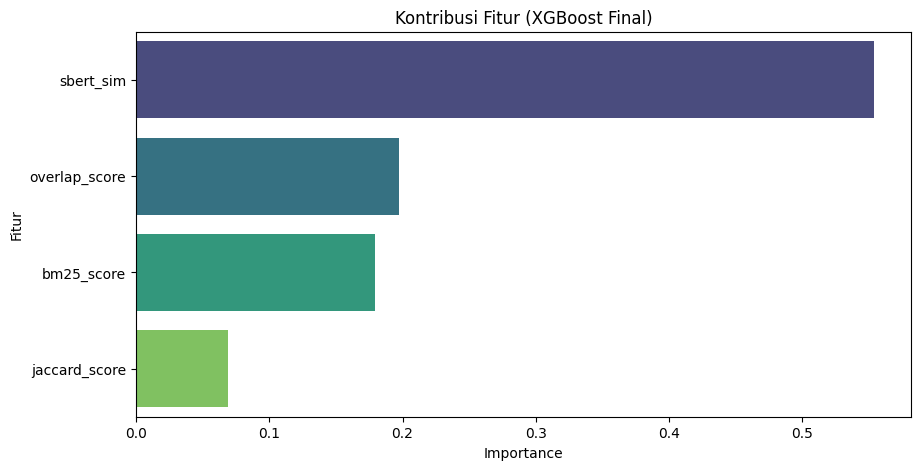

In [7]:
# Simpan Model JSON
model_path = os.path.join(MODEL_DIR, MODEL_FILENAME)
model.save_model(model_path)
print(f"Model tersimpan di: {model_path}")

# Visualisasi Feature Importance
importance = model.feature_importances_
feat_imp = pd.DataFrame({'Fitur': FEATURES, 'Importance': importance}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Fitur', data=feat_imp, palette='viridis')
plt.title('Kontribusi Fitur (XGBoost Final)')
plt.show()

Mengevaluasi Model & Mencari Threshold Optimal...

TARGET RECALL: 85.0%
   -> Threshold Optimal : 0.2919
   -> Recall Dicapai    : 0.8503
   -> Precision         : 0.3689
   -> ROC-AUC Score     : 0.8073

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.52      0.66     25556
           1       0.37      0.85      0.51      8519

    accuracy                           0.60     34075
   macro avg       0.64      0.68      0.59     34075
weighted avg       0.78      0.60      0.62     34075



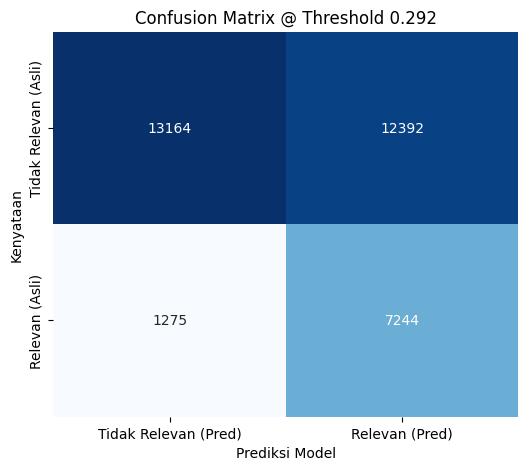

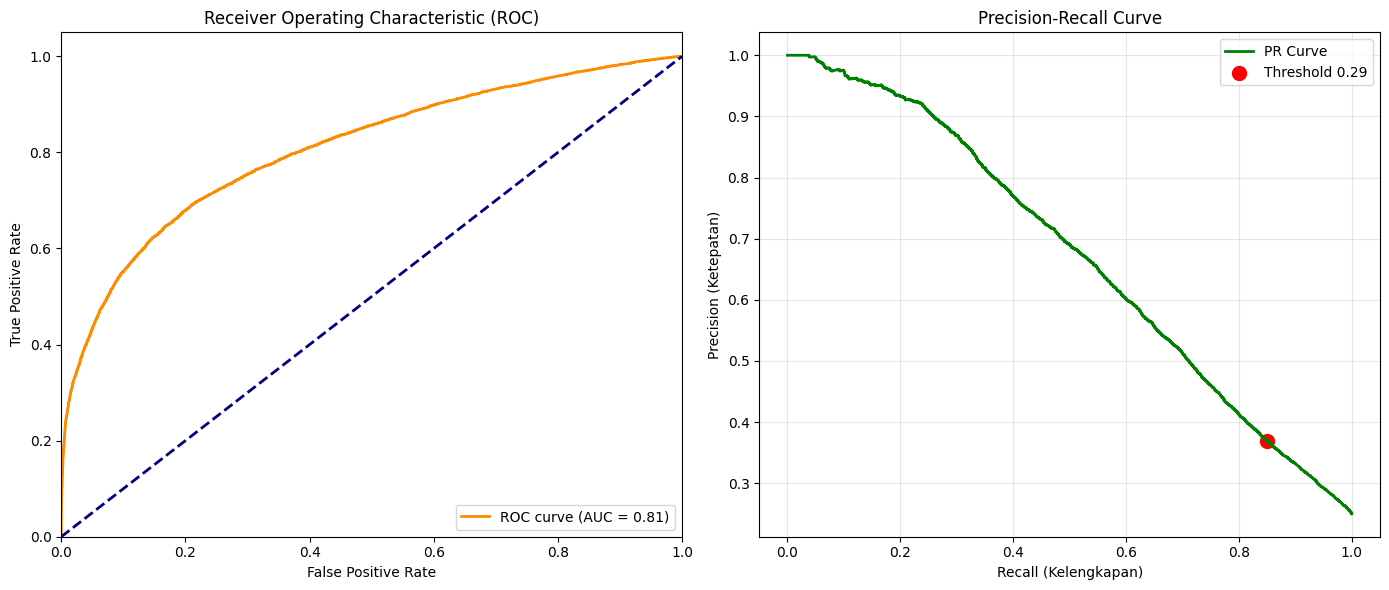


Nilai threshold disimpan ke: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\threshold.txt


In [11]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, auc

print("Mengevaluasi Model & Mencari Threshold Optimal...")

# 1. Ambil Probabilitas Prediksi (Skor 0.0 - 1.0)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Hitung Kurva Precision-Recall untuk mencari Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Cari indeks dimana Recall >= Target (0.85)
valid_indices = np.where(recall >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    idx = valid_indices[-1]
    best_thresh = thresholds[idx]
    rec_at_thresh = recall[idx]
    prec_at_thresh = precision[idx]
else:
    best_thresh = 0.5
    rec_at_thresh = 0
    prec_at_thresh = 0

# 3. Terapkan Threshold ke Prediksi
y_pred_final = (y_prob >= best_thresh).astype(int)

# --- TAMPILKAN HASIL ---

print(f"\nTARGET RECALL: {TARGET_RECALL*100}%")
print(f"   -> Threshold Optimal : {best_thresh:.4f}")
print(f"   -> Recall Dicapai    : {rec_at_thresh:.4f}")
print(f"   -> Precision         : {prec_at_thresh:.4f}")
print(f"   -> ROC-AUC Score     : {roc_auc_score(y_test, y_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# 4. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tidak Relevan (Pred)', 'Relevan (Pred)'],
            yticklabels=['Tidak Relevan (Asli)', 'Relevan (Asli)'])
plt.title(f'Confusion Matrix @ Threshold {best_thresh:.3f}')
plt.ylabel('Kenyataan')
plt.xlabel('Prediksi Model')
plt.show()

# 5. Visualisasi Kurva ROC & Precision-Recall
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[0].legend(loc="lower right")

# Plot Precision-Recall Curve
ax[1].plot(recall, precision, color='green', lw=2, label='PR Curve')
ax[1].scatter(rec_at_thresh, prec_at_thresh, s=100, c='red', label=f'Threshold {best_thresh:.2f}')
ax[1].set_xlabel('Recall (Kelengkapan)')
ax[1].set_ylabel('Precision (Ketepatan)')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Simpan Threshold
thresh_path = os.path.join(MODEL_DIR, THRESHOLD_FILENAME)
with open(thresh_path, 'w') as f:
    f.write(str(best_thresh))
print(f"\nNilai threshold disimpan ke: {thresh_path}")

In [27]:
# UJI COBA SEARCH ENGINE MANUAL
import pandas as pd
import xgboost as xgb
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import string
import nltk
from nltk.corpus import stopwords
import torch

# --- 1. SETUP RESOURCES ---
print("Memuat resource untuk pencarian...")

# A. Load Model SBERT
# Coba load dari folder models/ jika ada, kalau tidak pakai default
sbert_path = os.path.join(MODEL_DIR, 'sbert_finetuned')
if not os.path.exists(sbert_path):
    sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
else:
    sbert_model = SentenceTransformer(sbert_path)

# B. Load XGBoost
bst = xgb.Booster()
bst.load_model(os.path.join(MODEL_DIR, MODEL_FILENAME))

# C. Load Threshold
with open(os.path.join(MODEL_DIR, THRESHOLD_FILENAME), 'r') as f:
    THRESHOLD = float(f.read().strip())

# D. Persiapan Data Tafsir (Corpus)
# Kita ambil teks unik dari dataset
unique_tafsirs = df['text'].unique().tolist()
corpus_embeddings = sbert_model.encode(unique_tafsirs, convert_to_tensor=True, show_progress_bar=False)

# E. Persiapan BM25 & Stopwords
try:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set(['yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'kepada', 'pada', 'adalah'])

def clean_tokens(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    return [w for w in tokens if w not in stop_words]

corpus_tokens = [clean_tokens(doc) for doc in unique_tafsirs]
bm25 = BM25Okapi(corpus_tokens)

print("Sistem Siap! Threshold saat ini:", THRESHOLD)

# --- 2. FUNGSI PENCARIAN ---
def cari_ayat(query_text):
    print(f"\n🔍 QUERY: '{query_text}'")
    print("-" * 50)
    
    # 1. Retrieval (SBERT Top-50)
    query_vec = sbert_model.encode(query_text, convert_to_tensor=True)
    hits = util.semantic_search(query_vec, corpus_embeddings, top_k=50)[0]
    
    # 2. Feature Extraction
    candidates = []
    q_toks = clean_tokens(query_text)
    
    for hit in hits:
        doc_idx = hit['corpus_id']
        t_toks = corpus_tokens[doc_idx]
        
        # Hitung Fitur Lexical
        set_q = set(q_toks)
        set_t = set(t_toks)
        if len(set_q) > 0:
            overlap = len(set_q.intersection(set_t)) / len(set_q)
            jaccard = len(set_q.intersection(set_t)) / (len(set_q.union(set_t)) + 1e-9)
        else:
            overlap, jaccard = 0.0, 0.0
            
        bm25_score = bm25.get_batch_scores(q_toks, [doc_idx])[0]
        
        candidates.append({
            'text': unique_tafsirs[doc_idx],
            'sbert_sim': hit['score'],
            'bm25_score': bm25_score,
            'overlap_score': overlap,
            'jaccard_score': jaccard
        })
    
    # 3. Re-Ranking (XGBoost)
    df_cand = pd.DataFrame(candidates)
    # Pastikan urutan fitur sama dengan saat training
    dtest = xgb.DMatrix(df_cand[FEATURES])
    df_cand['final_score'] = bst.predict(dtest)
    
    # 4. Filter & Tampilkan
    results = df_cand[df_cand['final_score'] > THRESHOLD].sort_values('final_score', ascending=False)
    
    if len(results) == 0:
        print("Tidak ada hasil relevan (di bawah threshold).")
    else:
        print(f"Ditemukan {len(results)} hasil relevan:\n")
        for i, row in enumerate(results.head(3).iterrows()):
            idx, data = row
            print(f"[Peringkat {i+1}] Skor: {data['final_score']:.4f}")
            print(f"   (SBERT: {data['sbert_sim']:.2f} | BM25: {data['bm25_score']:.1f})")
            print(f"   Tafsir: {data['text'][:200]}...")
            print("")

Memuat resource untuk pencarian...
Sistem Siap! Threshold saat ini: 0.29192793


In [26]:
cari_ayat("Kisah sapi betina bani israil")
cari_ayat("Tanda-tanda orang munafik")
cari_ayat("Hukum warisan bagi perempuan")


🔍 QUERY: 'Kisah sapi betina bani israil'
--------------------------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x768 and 384x6031)

In [23]:
# ==========================================
# 8. UJI COBA SEARCH ENGINE (FINAL)
# ==========================================
import pandas as pd
import xgboost as xgb
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import string
import nltk
from nltk.corpus import stopwords
import torch
import os
import sys

# --- 1. KONFIGURASI PATH ---
# Karena notebook di folder scripts/, gunakan ROOT_DIR
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
METADATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')
DATA_TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')

# Nama folder harus persis dengan yang ada di komputer Anda
SBERT_FOLDER_NAME = 'sbert_finetuned_quran' 
XGB_FILENAME = 'xgboost_best_model.json'
THRESH_FILENAME = 'threshold.txt'

# Fitur yang digunakan (urutan harus sama dengan training)
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']

# --- 2. VALIDASI DAN LOAD MODEL SBERT ---
print("[INFO] Memuat resource...")

sbert_path = os.path.join(MODEL_DIR, SBERT_FOLDER_NAME)

# Cek keberadaan folder SBERT
if not os.path.exists(sbert_path):
    print("\n[FATAL ERROR] Model SBERT Fine-Tuned TIDAK DITEMUKAN!")
    print(f"Lokasi yang dicari: {sbert_path}")
    print("Pastikan folder 'sbert_finetuned_quran' ada di dalam folder 'models/'")
    raise FileNotFoundError("Wajib menggunakan SBERT Fine-tuned.")

print(f"   -> Model SBERT ditemukan di: {sbert_path}")
# Load SBERT (fix_mistral_regex=True ditambahkan untuk menghindari warning tokenizer)
try:
    sbert_model = SentenceTransformer(sbert_path, trust_remote_code=True)
    print(f"   -> Model SBERT Fine-tuned berhasil dimuat!")
except Exception as e:
    # Fallback jika parameter trust_remote_code tidak didukung versi lama
    print(f"   -> Warning: {e}")
    print(f"   -> Mencoba load tanpa trust_remote_code...")
    sbert_model = SentenceTransformer(sbert_path)
    print(f"   -> Model SBERT Fine-tuned berhasil dimuat!")

# --- 3. LOAD XGBOOST & THRESHOLD ---
xgb_path = os.path.join(MODEL_DIR, XGB_FILENAME)
if not os.path.exists(xgb_path):
    raise FileNotFoundError(f"[ERROR] Model XGBoost tidak ditemukan di {xgb_path}")

bst = xgb.Booster()
bst.load_model(xgb_path)

thresh_path = os.path.join(MODEL_DIR, THRESH_FILENAME)
if os.path.exists(thresh_path):
    with open(thresh_path, 'r') as f:
        THRESHOLD = float(f.read().strip())
else:
    print("[WARNING] File threshold tidak ada, menggunakan default 0.30")
    THRESHOLD = 0.30

# --- 4. PERSIAPAN DATA (CORPUS & METADATA) ---
# Load Metadata (Mapping Tafsir -> Surat/Ayat)
metadata_map = {}
if os.path.exists(METADATA_PATH):
    try:
        df_meta = pd.read_csv(METADATA_PATH)
        # Normalisasi nama kolom
        df_meta.columns = df_meta.columns.str.strip().str.lower()
        
        # Deteksi nama kolom yang bervariasi
        col_tafsir = next((c for c in df_meta.columns if 'tafsir' in c or 'text' in c), None)
        col_surah = next((c for c in df_meta.columns if 'surah' in c or 'surat' in c), None)
        col_ayah = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)

        if col_tafsir and col_surah:
            for _, row in df_meta.iterrows():
                clean_txt = str(row[col_tafsir]).strip()
                ayah_num = row[col_ayah] if col_ayah else "?"
                ayat_info = f"QS. {row[col_surah]} : Ayat {ayah_num}"
                metadata_map[clean_txt] = ayat_info
            print(f"   -> Metadata dimuat: {len(metadata_map)} entri")
    except Exception as e:
        print(f"[WARNING] Gagal memuat metadata: {e}")
else:
    print(f"[WARNING] File metadata tidak ditemukan di {METADATA_PATH}")

# Load Corpus dari Data Train untuk Indexing Pencarian
if 'df' not in locals():
    # Load ulang jika variabel df hilang dari memori
    if os.path.exists(DATA_TRAIN_PATH):
        df = pd.read_csv(DATA_TRAIN_PATH, on_bad_lines='skip')
        if len(df.columns) <= 1: 
            df = pd.read_csv(DATA_TRAIN_PATH, sep=';', on_bad_lines='skip')
        df.columns = df.columns.str.strip().str.replace('"', '').str.replace("'", "")
    else:
        print(f"[ERROR] Data training tidak ditemukan di {DATA_TRAIN_PATH}")
        print(f"[INFO] Menggunakan variabel df yang sudah ada di memori")

# Ambil teks unik untuk dijadikan index pencarian
unique_tafsirs = df['text'].unique().tolist()
print(f"   -> Mengindex {len(unique_tafsirs)} dokumen tafsir...")

# Encode Corpus dengan SBERT Fine-tuned
print(f"   -> Encoding corpus dengan SBERT Fine-tuned...")
corpus_embeddings = sbert_model.encode(unique_tafsirs, convert_to_tensor=True, show_progress_bar=True)

# Setup BM25 & Stopwords
try:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set(['yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk'])

def clean_tokens(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    return [w for w in tokens if w not in stop_words]

corpus_tokens = [clean_tokens(doc) for doc in unique_tafsirs]
bm25 = BM25Okapi(corpus_tokens)

print(f"[SUCCESS] Sistem Siap Digunakan. Threshold: {THRESHOLD:.4f}")
print(f"[SUCCESS] Menggunakan Model: {SBERT_FOLDER_NAME}")

# --- 5. FUNGSI PENCARIAN UTAMA ---
def cari_ayat(query_text):
    print(f"\n[QUERY] {query_text}")
    print("-" * 60)
    
    # 1. Retrieval (SBERT Semantic Search)
    query_vec = sbert_model.encode(query_text, convert_to_tensor=True)
    hits = util.semantic_search(query_vec, corpus_embeddings, top_k=50)[0]
    
    # 2. Feature Calculation
    candidates = []
    q_toks = clean_tokens(query_text)
    
    for hit in hits:
        doc_idx = hit['corpus_id']
        txt = unique_tafsirs[doc_idx]
        t_toks = corpus_tokens[doc_idx]
        
        # Hitung Lexical Features
        set_q, set_t = set(q_toks), set(t_toks)
        if len(set_q) > 0:
            overlap = len(set_q.intersection(set_t)) / len(set_q)
            jaccard = len(set_q.intersection(set_t)) / (len(set_q.union(set_t)) + 1e-9)
        else:
            overlap, jaccard = 0.0, 0.0
            
        bm25_score = bm25.get_batch_scores(q_toks, [doc_idx])[0]
        
        candidates.append({
            'text': txt,
            'sbert_sim': hit['score'],
            'bm25_score': bm25_score,
            'overlap_score': overlap,
            'jaccard_score': jaccard
        })
    
    # 3. Re-Ranking dengan XGBoost
    df_cand = pd.DataFrame(candidates)
    dtest = xgb.DMatrix(df_cand[FEATURES])
    df_cand['final_score'] = bst.predict(dtest)
    
    # 4. Filter dengan Threshold & Sorting
    results = df_cand[df_cand['final_score'] > THRESHOLD].sort_values('final_score', ascending=False)
    
    # 5. Tampilkan Hasil
    if len(results) == 0:
        print("[INFO] Tidak ada hasil yang memenuhi threshold relevansi.")
    else:
        print(f"[INFO] Ditemukan {len(results)} ayat relevan:\n")
        # Tampilkan Top 3
        for i, row in enumerate(results.head(3).iterrows()):
            idx, data = row
            tafsir_text = data['text']
            
            # Ambil info surat/ayat dari metadata
            lokasi = metadata_map.get(tafsir_text.strip(), "Lokasi tidak ditemukan di metadata")
            
            print(f"Peringkat {i+1} | Skor Relevansi: {data['final_score']:.4f}")
            print(f"Lokasi   : {lokasi}")
            print(f"Tafsir   : \"{tafsir_text[:200]}...\"")
            print("-" * 30)

# --- 6. JALANKAN TEST ---
cari_ayat("Bagaimana hukum pembagian warisan anak perempuan?")
cari_ayat("Kisah sapi betina bani israil")

[INFO] Memuat resource...
   -> Model SBERT ditemukan di: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


   -> Model SBERT Fine-tuned berhasil dimuat!
   -> Metadata dimuat: 6115 entri
   -> Mengindex 6031 dokumen tafsir...
   -> Encoding corpus dengan SBERT Fine-tuned...


Batches:   0%|          | 0/189 [00:00<?, ?it/s]

[SUCCESS] Sistem Siap Digunakan. Threshold: 0.2919
[SUCCESS] Menggunakan Model: sbert_finetuned_quran

[QUERY] Bagaimana hukum pembagian warisan anak perempuan?
------------------------------------------------------------
[INFO] Ditemukan 22 ayat relevan:

Peringkat 1 | Skor Relevansi: 0.9969
Lokasi   : Lokasi tidak ditemukan di metadata
Tafsir   : "Setelah ayat sebelumnya menjelaskan dampak orang yang mengabaikan hak orang lain, ayat ini menjelaskan ketentuan pembagian harta warisan yang dijelaskan Allah secara rinci agar tidak diabaikan. Allah ..."
------------------------------
Peringkat 2 | Skor Relevansi: 0.9070
Lokasi   : Lokasi tidak ditemukan di metadata
Tafsir   : "Setelah dijelaskan tentang perincian bagian warisan sebab nasab, berikut ini dijelaskan tentang pembagian warisan karena perkawinan. Dan adapun bagian kamu, wahai para suami, apabila ditinggal mati is..."
------------------------------
Peringkat 3 | Skor Relevansi: 0.8941
Lokasi   : Lokasi tidak ditemukan di metadat

In [24]:
import pickle
import torch
import os

# --- KONFIGURASI PENYIMPANAN ---
# Pastikan path ini mengarah ke folder models di repo Anda
SAVE_DIR = 'models' 
EMBEDDING_FILE = os.path.join(SAVE_DIR, 'corpus_embeddings.pt')
DATA_FILE = os.path.join(SAVE_DIR, 'corpus_data.pkl')

print(f"Sedang menyimpan hasil encoding ke folder '{SAVE_DIR}'...")

# 1. Pastikan folder ada
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# 2. Simpan Embeddings (Format PyTorch paling efisien/cepat)
# Variabel 'corpus_embeddings' diambil dari memori Anda saat ini
torch.save(corpus_embeddings, EMBEDDING_FILE)
print(f"Embeddings tersimpan: {EMBEDDING_FILE}")

# 3. Simpan Teks Asli & Metadata
# Kita wajib menyimpan teks aslinya juga agar urutan index-nya tidak tertukar
cache_data = {
    'unique_tafsirs': unique_tafsirs, # List teks tafsir
    'metadata_map': metadata_map      # Dictionary surat/ayat
}

with open(DATA_FILE, 'wb') as f:
    pickle.dump(cache_data, f)
print(f"Data Teks & Metadata tersimpan: {DATA_FILE}")

print("\nSELESAI! Sekarang Anda tidak perlu menunggu 6 menit lagi.")

Sedang menyimpan hasil encoding ke folder 'models'...
Embeddings tersimpan: models\corpus_embeddings.pt
Data Teks & Metadata tersimpan: models\corpus_data.pkl

SELESAI! Sekarang Anda tidak perlu menunggu 6 menit lagi.


In [25]:
# --- LOGIKA LOADING DI APLIKASI NANTI ---
import pickle
import torch
import os

# Path file yang tadi disimpan
EMBEDDING_FILE = 'models/corpus_embeddings.pt'
DATA_FILE = 'models/corpus_data.pkl'

if os.path.exists(EMBEDDING_FILE) and os.path.exists(DATA_FILE):
    print("⚡ [CACHE] Memuat data dari file (Super Cepat)...")
    
    # 1. Load Embeddings
    corpus_embeddings = torch.load(EMBEDDING_FILE)
    
    # 2. Load Teks
    with open(DATA_FILE, 'rb') as f:
        data = pickle.load(f)
        unique_tafsirs = data['unique_tafsirs']
        metadata_map = data['metadata_map']
        
    print(f"   -> Berhasil memuat {len(unique_tafsirs)} dokumen.")
else:
    print("🐢 [INIT] Cache tidak ditemukan. Melakukan Encoding (Lama)...")
    # ... Kode encoding lama (sbert.encode) ditaruh di sini ...

⚡ [CACHE] Memuat data dari file (Super Cepat)...
   -> Berhasil memuat 6031 dokumen.


In [26]:
# --- REVISI BAGIAN: LOAD CORPUS ---
# JANGAN load dari Data Train lagi untuk indexing
# GANTI dengan logika ini:

print(f"⚙️ Membangun Index Pencarian dari Master Data...")

# Pastikan Metadata (Master) ada
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"File Master '{METADATA_PATH}' tidak ditemukan! Wajib ada untuk index lengkap.")

# Baca file Master (tafsir_clean.csv)
df_master = pd.read_csv(METADATA_PATH)
df_master.columns = df_meta.columns.str.strip().str.lower() # Normalize header

# Cari kolom teks tafsir di file master
# Sesuaikan 'tafsir' dengan nama kolom asli di file csv anda
col_text_master = next((c for c in df_master.columns if 'tafsir' in c or 'text' in c), None)

if not col_text_master:
    raise ValueError("Kolom teks tafsir tidak ditemukan di file Master!")

# Ambil SEMUA ayat sebagai index
unique_tafsirs = df_master[col_text_master].astype(str).tolist()

print(f"✅ Corpus Master Terindeks: {len(unique_tafsirs)} dokumen")
# Harusnya sekarang muncul angka 6236 (atau mendekati jika ada duplikat persis)

# Lanjut ke Encoding...
corpus_embeddings = sbert_model.encode(unique_tafsirs, convert_to_tensor=True, show_progress_bar=True)

⚙️ Membangun Index Pencarian dari Master Data...
✅ Corpus Master Terindeks: 6236 dokumen


Batches:   0%|          | 0/195 [00:00<?, ?it/s]

In [27]:
import pickle
import torch
import os

# --- KONFIGURASI PENYIMPANAN ---
# Pastikan ini mengarah ke folder models di repo Anda
SAVE_DIR = 'models' 

# Nama file output
EMBEDDING_FILE = os.path.join(SAVE_DIR, 'corpus_embeddings.pt')
DATA_FILE = os.path.join(SAVE_DIR, 'corpus_data.pkl')

print(f"💾 Memulai penyimpanan ke folder '{SAVE_DIR}'...")

# 1. Pastikan folder ada
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"   -> Folder {SAVE_DIR} dibuat.")

# 2. Simpan Embeddings (Tensor PyTorch)
# Ini menyimpan hasil kerja keras SBERT tadi
try:
    torch.save(corpus_embeddings, EMBEDDING_FILE)
    print(f"   ✅ Embeddings berhasil disimpan: {EMBEDDING_FILE}")
except Exception as e:
    print(f"   ❌ Gagal menyimpan embeddings: {e}")

# 3. Simpan Teks Asli & Metadata
# Kita bungkus jadi satu paket biar rapi
cache_data = {
    'texts': unique_tafsirs,      # List teks tafsir (urut sesuai index embedding)
    'metadata': metadata_map      # Dictionary mapping {teks -> "QS. X:Y"}
}

try:
    with open(DATA_FILE, 'wb') as f:
        pickle.dump(cache_data, f)
    print(f"   ✅ Data Teks & Metadata berhasil disimpan: {DATA_FILE}")
except Exception as e:
    print(f"   ❌ Gagal menyimpan data teks: {e}")

print("\n🎉 SELESAI! Aset 'Search Engine' Anda sudah aman.")
print("Sekarang aplikasi Streamlit nanti bisa load data ini dalam < 1 detik.")

💾 Memulai penyimpanan ke folder 'models'...
   ✅ Embeddings berhasil disimpan: models\corpus_embeddings.pt
   ✅ Data Teks & Metadata berhasil disimpan: models\corpus_data.pkl

🎉 SELESAI! Aset 'Search Engine' Anda sudah aman.
Sekarang aplikasi Streamlit nanti bisa load data ini dalam < 1 detik.


In [29]:
print("Menghitung Metrik Ranking Lengkap (termasuk Recall)...")

# Ambil data test lengkap (termasuk kolom query)
test_df = df.iloc[idx_test].copy()
test_df['pred_score'] = y_prob

metrics = {
    'MRR': [],
    'MAP': [],
    'NDCG@5': [],
    'P@1': [],
    'P@3': [],
    'Recall@5': [],
    'Recall@10': []
}

# Grouping per Query
grouped = test_df.groupby('query')
valid_queries = 0

for query, group in grouped:
    # Hitung total jawaban benar (relevan) yang tersedia untuk query ini
    total_relevan = group['label'].sum()
    
    # Skip query yang tidak punya jawaban benar di data test (tidak bisa dihitung recall-nya)
    if total_relevan < 1:
        continue
    valid_queries += 1
    
    # Sorting berdasarkan prediksi skor (Ranking AI)
    sorted_group = group.sort_values(by='pred_score', ascending=False)
    
    y_true_sorted = sorted_group['label'].values
    y_score_sorted = sorted_group['pred_score'].values
    
    # 1. MRR (Mean Reciprocal Rank)
    try:
        rank = np.where(y_true_sorted == 1)[0][0] + 1
        metrics['MRR'].append(1 / rank)
    except IndexError:
        metrics['MRR'].append(0)
        
    # 2. MAP (Mean Average Precision)
    metrics['MAP'].append(average_precision_score(y_true_sorted, y_score_sorted))
    
    # 3. NDCG@5
    try:
        metrics['NDCG@5'].append(ndcg_score([y_true_sorted], [y_score_sorted], k=5))
    except:
        metrics['NDCG@5'].append(0)
        
    # 4. Precision at K
    p1 = y_true_sorted[0] 
    p3 = np.sum(y_true_sorted[:3]) / 3
    metrics['P@1'].append(p1)
    metrics['P@3'].append(p3)

    # 5. Recall at K (BARU)
    # Rumus: (Jumlah Relevan di Top-K) / (Total Relevan di seluruh database)
    r5 = np.sum(y_true_sorted[:5]) / total_relevan
    r10 = np.sum(y_true_sorted[:10]) / total_relevan
    
    metrics['Recall@5'].append(r5)
    metrics['Recall@10'].append(r10)

# Tampilkan Hasil Rata-rata
print("\n=== LAPORAN PERFORMA SEARCH ENGINE ===")
print(f"Total Query Diuji: {valid_queries}")
print("-" * 40)
print(f"Precision@1 (Top 1 Benar): {np.mean(metrics['P@1']):.2%}")
print(f"MRR Score                : {np.mean(metrics['MRR']):.4f}")
print(f"NDCG@5 Score             : {np.mean(metrics['NDCG@5']):.4f}")
print("-" * 40)
print(f"Recall@5  (Cakupan Top 5) : {np.mean(metrics['Recall@5']):.2%}")
print(f"Recall@10 (Cakupan Top 10): {np.mean(metrics['Recall@10']):.2%}")
print("=" * 40)

if np.mean(metrics['Recall@10']) < 0.8:
    print("⚠️ PERINGATAN: Recall@10 di bawah 80%.")
    print("   Artinya masih ada jawaban benar yang 'tenggelam' ke halaman 2 atau lebih.")
    print("   User mungkin perlu scroll jauh untuk menemukannya.")
else:
    print("✅ STATUS: Recall@10 Tinggi. Sebagian besar jawaban ada di Halaman 1.")

Menghitung Metrik Ranking Lengkap (termasuk Recall)...

=== LAPORAN PERFORMA SEARCH ENGINE ===
Total Query Diuji: 8519
----------------------------------------
Precision@1 (Top 1 Benar): 90.96%
MRR Score                : 0.9525
NDCG@5 Score             : 0.4605
----------------------------------------
Recall@5  (Cakupan Top 5) : 100.00%
Recall@10 (Cakupan Top 10): 100.00%
✅ STATUS: Recall@10 Tinggi. Sebagian besar jawaban ada di Halaman 1.


In [10]:
# ==========================================
# UJI COBA SEARCH ENGINE (RELEVAN + METADATA)
# ==========================================
import pandas as pd
import xgboost as xgb
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import string
import nltk
from nltk.corpus import stopwords
import torch
import os

# --- 0. KONFIGURASI PATH (Sesuaikan jika perlu) ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'models')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
# Path ke file master untuk ambil nama surat/ayat
METADATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv') 

MODEL_FILENAME = 'xgboost_best_model.json' # Sesuaikan nama file model
THRESHOLD_FILENAME = 'threshold.txt'
SBERT_FOLDER_NAME = 'sbert_finetuned_quran'
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']

# --- 1. SETUP RESOURCES ---
print("⚙️ Memuat resource...")

# A. Load SBERT
sbert_path = os.path.join(MODEL_DIR, SBERT_FOLDER_NAME)
if not os.path.exists(sbert_path):
    # Fallback cari di root
    if os.path.exists(SBERT_FOLDER_NAME): sbert_path = SBERT_FOLDER_NAME
    else: sbert_path = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'

print(f"   -> SBERT: {sbert_path}")
try:
    sbert_model = SentenceTransformer(sbert_path, device='cpu', trust_remote_code=True)
except:
    sbert_model = SentenceTransformer(sbert_path, device='cpu')

# B. Load XGBoost
xgb_path = os.path.join(MODEL_DIR, MODEL_FILENAME)
bst = xgb.Booster()
bst.load_model(xgb_path)

# C. Load Threshold
thresh_path = os.path.join(MODEL_DIR, THRESHOLD_FILENAME)
if os.path.exists(thresh_path):
    with open(thresh_path, 'r') as f:
        THRESHOLD = float(f.read().strip())
else:
    THRESHOLD = 0.3

# D. Persiapan Data Tafsir (TETAP PAKAI SUMBER YANG SUKSES TADI)
# Asumsi 'df' masih ada di memori dari cell training sebelumnya.
if 'df' not in locals():
    raise ValueError("DataFrame 'df' dari training harus ada! Jangan load dari CSV lain.")

unique_tafsirs = df['text'].unique().tolist()
print(f"   -> Indexing {len(unique_tafsirs)} dokumen (SBERT)...")
corpus_embeddings = sbert_model.encode(unique_tafsirs, convert_to_tensor=True, show_progress_bar=False)

# E. Persiapan Metadata Map (INI TAMBAHANNYA)
# Kita buat kamus: { "Teks Tafsir A": "QS. Al-Baqarah: 1" }
print("   -> Membangun Peta Metadata (Surat/Ayat)...")
metadata_map = {}

if os.path.exists(METADATA_PATH):
    try:
        df_meta = pd.read_csv(METADATA_PATH)
        df_meta.columns = df_meta.columns.str.lower().str.strip()
        
        # Deteksi nama kolom
        col_t = next((c for c in df_meta.columns if 'tafsir' in c), None)
        col_s = next((c for c in df_meta.columns if 'surah' in c), None)
        col_a = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)
        
        if col_t and col_s:
            for _, row in df_meta.iterrows():
                # KUNCI RAHASIA: Bersihkan teks biar match (strip)
                txt_key = str(row[col_t]).strip()
                metadata_map[txt_key] = f"QS. {row[col_s]} : Ayat {row.get(col_a, '?')}"
        
        print(f"      ✅ Berhasil memetakan {len(metadata_map)} ayat.")
    except Exception as e:
        print(f"      ⚠️ Gagal load metadata: {e}")
else:
    print("      ⚠️ File metadata tidak ditemukan.")

# F. BM25
try:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set(['yang', 'dan', 'di'])

def clean_tokens(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return [w for w in text.split() if w not in stop_words]

corpus_tokens = [clean_tokens(doc) for doc in unique_tafsirs]
bm25 = BM25Okapi(corpus_tokens)

print(f"\n✅ SIAP! Threshold: {THRESHOLD:.4f}")

# --- 2. FUNGSI PENCARIAN ---
def cari_ayat(query_text):
    print(f"\n🔍 QUERY: '{query_text}'")
    print("-" * 50)
    
    # 1. Retrieval
    query_vec = sbert_model.encode(query_text, convert_to_tensor=True)
    hits = util.semantic_search(query_vec, corpus_embeddings, top_k=50)[0]
    
    # 2. Features
    candidates = []
    q_toks = clean_tokens(query_text)
    
    for hit in hits:
        doc_idx = hit['corpus_id']
        t_toks = corpus_tokens[doc_idx]
        
        set_q, set_t = set(q_toks), set(t_toks)
        if len(set_q) > 0:
            ov = len(set_q.intersection(set_t)) / len(set_q)
            jac = len(set_q.intersection(set_t)) / (len(set_q.union(set_t)) + 1e-9)
        else:
            ov, jac = 0.0, 0.0
            
        bm25_s = bm25.get_batch_scores(q_toks, [doc_idx])[0]
        
        candidates.append({
            'text': unique_tafsirs[doc_idx],
            'sbert_sim': hit['score'],
            'bm25_score': bm25_s,
            'overlap_score': ov,
            'jaccard_score': jac
        })
    
    # 3. Re-Ranking (XGBoost)
    df_cand = pd.DataFrame(candidates)
    dtest = xgb.DMatrix(df_cand[FEATURES])
    df_cand['final_score'] = bst.predict(dtest)
    
    # 4. Filter
    results = df_cand[df_cand['final_score'] > THRESHOLD].sort_values('final_score', ascending=False)
    
    if len(results) == 0:
        print("❌ Tidak ada hasil relevan.")
    else:
        print(f"✅ Ditemukan {len(results)} hasil relevan:\n")
        for i, row in enumerate(results.head(3).iterrows()):
            idx, data = row
            tafsir_text = data['text']
            
            # --- MAGIC MOMENT: AMBIL LOKASI DARI MAP ---
            # Kita cari teks tafsir ini punya siapa?
            lokasi = metadata_map.get(tafsir_text.strip(), "Lokasi tidak ditemukan (Cek Metadata)")
            
            print(f"🏅 [Peringkat {i+1}] Skor: {data['final_score']:.4f}")
            print(f"📖 {lokasi}") 
            print(f"💬 \"{tafsir_text[:200]}...\"")
            print("-" * 30)

# TEST
cari_ayat("Kisah sapi betina bani israil")
cari_ayat("Hukum warisan bagi perempuan")

⚙️ Memuat resource...
   -> SBERT: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


   -> Indexing 6031 dokumen (SBERT)...
   -> Membangun Peta Metadata (Surat/Ayat)...
      ✅ Berhasil memetakan 6020 ayat.

✅ SIAP! Threshold: 0.2919

🔍 QUERY: 'Kisah sapi betina bani israil'
--------------------------------------------------
✅ Ditemukan 39 hasil relevan:

🏅 [Peringkat 1] Skor: 0.9814
📖 QS. Al-Baqarah  : Ayat 51
💬 "Setelah menerima nikmat dalam bentuk penyelamatan dari dua bencana pembunuhan dan tenggelam di Laut Merah, Allah kemudian menyuruh Bani Israil agar mengingat lagi peristiwa penurunan wahyu kepada Nabi..."
------------------------------
🏅 [Peringkat 2] Skor: 0.9725
📖 QS. Al-A‘rāf : Ayat 105
💬 "Sebagai seorang nabi dan rasul yang bertugas menyampaikan pesan Allah, aku wajib mengatakan yang sebenarnya tentang Allah. Sungguh, untuk memperkuat kebenaran yang kubawa ini, aku datang kepadamu deng..."
------------------------------
🏅 [Peringkat 3] Skor: 0.9676
📖 QS. Al-Mā'idah : Ayat 72
💬 "Bila pada ayat-ayat yang lalu diterangkan tentang penyimpanganpenyimpangan ya

In [11]:
import pickle
import torch
import os

# --- CONFIGURATION ---
# Ensure we save to the models directory
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'models')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

SAVE_DIR = os.path.join(ROOT_DIR, 'models')
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# File names
EMBEDDING_FILE = os.path.join(SAVE_DIR, 'corpus_embeddings.pt')
DATA_FILE = os.path.join(SAVE_DIR, 'corpus_data.pkl')

print(f"💾 Saving indexing state to {SAVE_DIR}...")

# 1. Save the Tensor Embeddings
# This is the heavy lifting part we don't want to repeat
torch.save(corpus_embeddings, EMBEDDING_FILE)
print(f"   ✅ Embeddings saved: {EMBEDDING_FILE}")

# 2. Save the Text Data and Metadata Map
# We bundle them together to ensure they stay synchronized
data_package = {
    'texts': unique_tafsirs,      # The list of tafsir texts used for search (from training data)
    'metadata': metadata_map      # The dictionary mapping {text -> location info}
}

with open(DATA_FILE, 'wb') as f:
    pickle.dump(data_package, f)

print(f"   ✅ Data package saved: {DATA_FILE}")
print("\n🎉 SUCCESS! You can now run the Streamlit app without re-indexing.")

💾 Saving indexing state to c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models...
   ✅ Embeddings saved: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\corpus_embeddings.pt
   ✅ Data package saved: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\corpus_data.pkl

🎉 SUCCESS! You can now run the Streamlit app without re-indexing.


In [12]:
import pandas as pd
import os

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')
META_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_LENGKAP.csv')

print("🚀 MEMULAI PENGGABUNGAN DATASET...")

# 1. LOAD DATA
print("   -> Membaca Dataset Training...")
df_train = pd.read_csv(TRAIN_PATH, on_bad_lines='skip')
# Bersihkan nama kolom & data
df_train.columns = df_train.columns.str.strip().str.lower().str.replace('"', '')

print("   -> Membaca Metadata (Tafsir Clean)...")
df_meta = pd.read_csv(META_PATH)
df_meta.columns = df_meta.columns.str.strip().str.lower()

# 2. BUAT KAMUS PENCARIAN
# Kita buat dictionary: { "teks tafsir" : "QS. Al-Baqarah: 1" }
print("   -> Membuat Kamus Referensi...")
meta_dict = {}

col_t = next((c for c in df_meta.columns if 'tafsir' in c or 'text' in c), None)
col_s = next((c for c in df_meta.columns if 'surah' in c), None)
col_a = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)

if col_t and col_s:
    for _, row in df_meta.iterrows():
        # KUNCI: strip() agar spasi tidak mengganggu
        kunci = str(row[col_t]).strip()
        nilai = f"QS. {row[col_s]} : Ayat {row.get(col_a, '?')}"
        meta_dict[kunci] = nilai

# 3. TERAPKAN KE DATA TRAIN (MAPPING)
print("   -> Menambahkan kolom 'lokasi_ayat'...")

def cari_lokasi(text):
    return meta_dict.get(str(text).strip(), "Lokasi Tidak Ditemukan")

df_train['lokasi_ayat'] = df_train['text'].apply(cari_lokasi)

# 4. CEK HASIL
jumlah_ketemu = df_train[df_train['lokasi_ayat'] != "Lokasi Tidak Ditemukan"].shape[0]
total_data = df_train.shape[0]

print(f"   -> Berhasil mencocokkan: {jumlah_ketemu} dari {total_data} baris.")

# 5. SIMPAN FILE BARU
# Kita simpan kolom penting saja biar rapi
cols = list(df_train.columns)
# Taruh lokasi_ayat setelah text
if 'text' in cols:
    cols.insert(cols.index('text') + 1, 'lokasi_ayat')
    # Hapus duplikat nama kolom kalau ada
    cols = list(dict.fromkeys(cols))

df_train = df_train[cols]
df_train.to_csv(OUTPUT_PATH, index=False)

print(f"\n✅ FILE BARU TERSIMPAN: {OUTPUT_PATH}")
print("   Gunakan file ini untuk Indexing selanjutnya!")

🚀 MEMULAI PENGGABUNGAN DATASET...
   -> Membaca Dataset Training...
   -> Membaca Metadata (Tafsir Clean)...
   -> Membuat Kamus Referensi...
   -> Menambahkan kolom 'lokasi_ayat'...
   -> Berhasil mencocokkan: 0 dari 170372 baris.

✅ FILE BARU TERSIMPAN: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_LENGKAP.csv
   Gunakan file ini untuk Indexing selanjutnya!


In [13]:
import pandas as pd
import os

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')
META_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_LENGKAP.csv')

print("🚀 MEMULAI PENGGABUNGAN DATASET...")

# 1. LOAD DATA
print("   -> Membaca Dataset Training...")
df_train = pd.read_csv(TRAIN_PATH, on_bad_lines='skip')
# Bersihkan nama kolom & data
df_train.columns = df_train.columns.str.strip().str.lower().str.replace('"', '')

print("   -> Membaca Metadata (Tafsir Clean)...")
df_meta = pd.read_csv(META_PATH)
df_meta.columns = df_meta.columns.str.strip().str.lower()

# 2. BUAT KAMUS PENCARIAN
# Kita buat dictionary: { "teks tafsir" : "QS. Al-Baqarah: 1" }
print("   -> Membuat Kamus Referensi...")
meta_dict = {}

col_t = next((c for c in df_meta.columns if 'tafsir' in c or 'text' in c), None)
col_s = next((c for c in df_meta.columns if 'surah' in c), None)
col_a = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)

if col_t and col_s:
    for _, row in df_meta.iterrows():
        # KUNCI: strip() agar spasi tidak mengganggu
        kunci = str(row[col_t]).strip()
        nilai = f"QS. {row[col_s]} : Ayat {row.get(col_a, '?')}"
        meta_dict[kunci] = nilai

# 3. TERAPKAN KE DATA TRAIN (MAPPING)
print("   -> Menambahkan kolom 'lokasi_ayat'...")

def cari_lokasi(text):
    return meta_dict.get(str(text).strip(), "Lokasi Tidak Ditemukan")

df_train['lokasi_ayat'] = df_train['text'].apply(cari_lokasi)

# 4. CEK HASIL
jumlah_ketemu = df_train[df_train['lokasi_ayat'] != "Lokasi Tidak Ditemukan"].shape[0]
total_data = df_train.shape[0]

print(f"   -> Berhasil mencocokkan: {jumlah_ketemu} dari {total_data} baris.")

# 5. SIMPAN FILE BARU
# Kita simpan kolom penting saja biar rapi
cols = list(df_train.columns)
# Taruh lokasi_ayat setelah text
if 'text' in cols:
    cols.insert(cols.index('text') + 1, 'lokasi_ayat')
    # Hapus duplikat nama kolom kalau ada
    cols = list(dict.fromkeys(cols))

df_train = df_train[cols]
df_train.to_csv(OUTPUT_PATH, index=False)

print(f"\n✅ FILE BARU TERSIMPAN: {OUTPUT_PATH}")
print("   Gunakan file ini untuk Indexing selanjutnya!")

🚀 MEMULAI PENGGABUNGAN DATASET...
   -> Membaca Dataset Training...
   -> Membaca Metadata (Tafsir Clean)...
   -> Membuat Kamus Referensi...
   -> Menambahkan kolom 'lokasi_ayat'...
   -> Berhasil mencocokkan: 0 dari 170372 baris.

✅ FILE BARU TERSIMPAN: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_LENGKAP.csv
   Gunakan file ini untuk Indexing selanjutnya!


In [14]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
import os

# --- KONFIGURASI ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')
META_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_LENGKAP_AI.csv')
SBERT_PATH = os.path.join(ROOT_DIR, 'models', 'sbert_finetuned_quran')

print("☢️ MEMULAI OPERASI PENCOCOKAN SEMANTIK (AI MATCHING)...")

# 1. LOAD DATA
print("   -> Membaca Data...")
df_train = pd.read_csv(TRAIN_PATH, on_bad_lines='skip')
# Ambil Tafsir Unik saja dari training biar cepat (cuma ~6000 baris)
df_train_unique = df_train[['text']].drop_duplicates().astype(str)
texts_train = df_train_unique['text'].tolist()

df_meta = pd.read_csv(META_PATH)
df_meta.columns = df_meta.columns.str.lower().str.strip()
col_t = next(c for c in df_meta.columns if 'tafsir' in c or 'text' in c)
texts_meta = df_meta[col_t].astype(str).tolist()

print(f"   -> Training Unik: {len(texts_train)} | Metadata Total: {len(texts_meta)}")

# 2. LOAD SBERT
print("   -> Memuat SBERT...")
try:
    model = SentenceTransformer(SBERT_PATH, device='cpu', trust_remote_code=True)
except:
    model = SentenceTransformer(SBERT_PATH, device='cpu')

# 3. ENCODING KEDUA KUBU
print("   -> Encoding Metadata (Target)...")
emb_meta = model.encode(texts_meta, convert_to_tensor=True, show_progress_bar=True)

print("   -> Encoding Training Data (Source)...")
emb_train = model.encode(texts_train, convert_to_tensor=True, show_progress_bar=True)

# 4. PENCARIAN PASANGAN (SEMANTIC SEARCH)
print("   -> Mencari Pasangan Identik...")
# Cari 1 tetangga terdekat untuk setiap teks training di dalam database metadata
hits = util.semantic_search(emb_train, emb_meta, top_k=1)

# 5. MAPPING HASIL
# Kita buat kamus: { "Teks Training" : "Lokasi dari Metadata" }
ai_mapping = {}
match_count = 0

for i, hit in enumerate(hits):
    score = hit[0]['score']
    meta_idx = hit[0]['corpus_id']
    
    # Text asli dari training
    query_txt = texts_train[i]
    
    # Jika kemiripan sangat tinggi (> 0.95), berarti teksnya sama (cuma beda spasi/titik)
    if score > 0.95:
        # Ambil info surat/ayat dari baris metadata yang ketemu
        row = df_meta.iloc[meta_idx]
        col_s = next(c for c in df_meta.columns if 'surah' in c)
        col_a = next(c for c in df_meta.columns if 'ayah' in c or 'ayat' in c)
        
        lokasi = f"QS. {row[col_s]} : Ayat {row[col_a]}"
        ai_mapping[query_txt] = lokasi
        match_count += 1
    else:
        ai_mapping[query_txt] = "Lokasi Tidak Ditemukan (No Match)"

print(f"   -> BERHASIL MENJAHIT: {match_count} dari {len(texts_train)} tafsir unik.")

# 6. TERAPKAN KE DATASET TRAINING ASLI
print("   -> Menyimpan ke CSV Baru...")

def get_loc(text):
    return ai_mapping.get(str(text), "Lokasi Tidak Ditemukan")

df_train['lokasi_ayat'] = df_train['text'].apply(get_loc)

# Reorder & Save
cols = list(df_train.columns)
if 'text' in cols:
    cols.insert(cols.index('text') + 1, 'lokasi_ayat')
    cols = list(dict.fromkeys(cols))

df_train = df_train[cols]
df_train.to_csv(OUTPUT_PATH, index=False)

print(f"\n✅ FILE LENGKAP TERSIMPAN: {OUTPUT_PATH}")
print("   Sekarang file ini punya kolom 'lokasi_ayat' yang akurat hasil pencocokan AI.")

☢️ MEMULAI OPERASI PENCOCOKAN SEMANTIK (AI MATCHING)...
   -> Membaca Data...
   -> Training Unik: 6031 | Metadata Total: 6236
   -> Memuat SBERT...


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


   -> Encoding Metadata (Target)...


Batches:   0%|          | 0/195 [00:00<?, ?it/s]

   -> Encoding Training Data (Source)...


Batches:   0%|          | 0/189 [00:00<?, ?it/s]

   -> Mencari Pasangan Identik...
   -> BERHASIL MENJAHIT: 0 dari 6031 tafsir unik.
   -> Menyimpan ke CSV Baru...

✅ FILE LENGKAP TERSIMPAN: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_LENGKAP_AI.csv
   Sekarang file ini punya kolom 'lokasi_ayat' yang akurat hasil pencocokan AI.


In [15]:
import pandas as pd
import os

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Nama File Output Baru
OUTPUT_CSV = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_METADATA.csv')

print("🚀 MENYIMPAN DATASET DENGAN KOLOM BARU...")

# 1. PASTIKAN VARIABEL MASIH ADA (Dari cell sukses tadi)
if 'df' not in locals():
    raise ValueError("Variabel 'df' hilang! Jangan restart kernel dulu.")
if 'metadata_map' not in locals():
    raise ValueError("Variabel 'metadata_map' hilang! Jalankan kode pencarian sukses tadi dulu.")

# 2. TEMPELKAN METADATA KE DATAFRAME
print("   -> Menambahkan kolom 'ayat_asal'...")

# Fungsi tempel (Lookup ke dictionary sukses tadi)
def get_ayat(text):
    # Kunci: strip() karena dictionary tadi kuncinya di-strip
    return metadata_map.get(str(text).strip(), "Lokasi Tidak Ditemukan")

# Kita buat copy biar df asli aman
df_final = df.copy()
df_final['ayat_asal'] = df_final['text'].apply(get_ayat)

# 3. CEK DATA YANG MASUK
sukses = df_final[df_final['ayat_asal'] != "Lokasi Tidak Ditemukan"].shape[0]
total = df_final.shape[0]

print(f"   -> Berhasil mengisi kolom ayat: {sukses} dari {total} baris.")

# 4. ATUR URUTAN KOLOM (Biar enak dilihat)
cols = list(df_final.columns)
# Pindahkan ayat_asal ke sebelah text
if 'text' in cols:
    cols.insert(cols.index('text') + 1, 'ayat_asal')
    # Hapus duplikat kolom di list
    cols = list(dict.fromkeys(cols))
    df_final = df_final[cols]

# 5. SIMPAN CSV
df_final.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ BERHASIL! File tersimpan di:\n   {OUTPUT_CSV}")
print("\n🔍 Preview 5 Baris Pertama:")
print(df_final[['text', 'ayat_asal']].head(5))

🚀 MENYIMPAN DATASET DENGAN KOLOM BARU...
   -> Menambahkan kolom 'ayat_asal'...
   -> Berhasil mengisi kolom ayat: 170372 dari 170372 baris.

✅ BERHASIL! File tersimpan di:
   c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_FULL_METADATA.csv

🔍 Preview 5 Baris Pertama:
                                                text  \
0  Kekalahan mereka di dunia bukan akhir segalany...   
1  dan tetumbuhan tak berbatang dan pepohonan ber...   
2  Seandainya orang kafir itu mengetahui dengan p...   
3  Dan demikianlah Kami wahyukan kepadamu, wahai ...   
4  Maka, pada saat datang azab kepada mereka seca...   

                     ayat_asal  
0       QS. Al-Qamar : Ayat 46  
1       QS. Ar-Raḥmān : Ayat 6  
2    QS. Al-Anbiyā'  : Ayat 39  
3      QS. Asy-Syūrā : Ayat 52  
4  QS. Asy-Syu‘arā' : Ayat 202  


In [16]:
import pandas as pd
import os

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Input
TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')
META_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')

# Output Final
OUTPUT_CSV = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

print("🚀 MEMULAI PEMBUATAN DATASET PAKET LENGKAP...")

# 1. LOAD DATA
# Kita load fresh dari file biar aman
print("   -> Membaca Data Training...")
df_train = pd.read_csv(TRAIN_PATH, on_bad_lines='skip')
df_train.columns = df_train.columns.str.strip().str.lower().str.replace('"', '')

print("   -> Membaca Metadata (Tafsir Clean)...")
df_meta = pd.read_csv(META_PATH)
df_meta.columns = df_meta.columns.str.strip().str.lower()

# 2. BANGUN "SUPER DICTIONARY"
# Kuncinya tetap Teks Tafsir, tapi isinya kita ambil semuanya
print("   -> Membangun Kamus Super Lengkap...")
super_map = {}

# Deteksi kolom di metadata
col_t = next((c for c in df_meta.columns if 'tafsir' in c or 'text' in c), None)
col_s = next((c for c in df_meta.columns if 'surah' in c), None)
col_a = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)
col_arab = next((c for c in df_meta.columns if 'arab' in c), None)
col_trans = next((c for c in df_meta.columns if 'indo' in c or 'trans' in c or 'terjemah' in c), None)

if col_t and col_s:
    for _, row in df_meta.iterrows():
        # KUNCI: strip()
        key = str(row[col_t]).strip()
        
        # Simpan Paket Lengkap
        super_map[key] = {
            'ayat_asal': f"QS. {row[col_s]} : Ayat {row.get(col_a, '?')}",
            'arabic': row.get(col_arab, ''),
            'translation': row.get(col_trans, '')
        }

print(f"      Kamus siap: {len(super_map)} entri.")

# 3. TERAPKAN KE DATA TRAIN
print("   -> Menjahit kolom baru ke Data Train...")

# Fungsi Helper biar rapi
def get_info(text, field):
    # Default kosong jika tidak ketemu
    val = super_map.get(str(text).strip())
    if val:
        return val[field]
    return "Tidak Ditemukan"

# Buat 3 Kolom Baru Sekaligus
df_train['ayat_asal'] = df_train['text'].apply(lambda x: get_info(x, 'ayat_asal'))
df_train['arabic'] = df_train['text'].apply(lambda x: get_info(x, 'arabic'))
df_train['translation'] = df_train['text'].apply(lambda x: get_info(x, 'translation'))

# 4. CEK KUALITAS
sukses = df_train[df_train['ayat_asal'] != "Tidak Ditemukan"].shape[0]
total = len(df_train)
print(f"   -> Berhasil melengkapi: {sukses} dari {total} baris ({sukses/total:.1%})")

# 5. RAPIKAN URUTAN KOLOM
cols = list(df_train.columns)
# Kita mau urutan: query, text, ayat_asal, arabic, translation, label, ... sisanya
target_order = ['query', 'text', 'ayat_asal', 'arabic', 'translation', 'label']
remaining = [c for c in cols if c not in target_order]
final_order = target_order + remaining

# Filter kolom yang benar-benar ada saja
final_cols = [c for c in final_order if c in df_train.columns]
df_train = df_train[final_cols]

# 6. SIMPAN
df_train.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ DATASET LENGKAP TERSIMPAN: {OUTPUT_CSV}")

print("\n🔍 Preview Data (Pastikan Arab & Terjemah Muncul):")
print(df_train[['ayat_asal', 'arabic', 'translation']].head(3))

🚀 MEMULAI PEMBUATAN DATASET PAKET LENGKAP...
   -> Membaca Data Training...
   -> Membaca Metadata (Tafsir Clean)...
   -> Membangun Kamus Super Lengkap...
      Kamus siap: 6115 entri.
   -> Menjahit kolom baru ke Data Train...
   -> Berhasil melengkapi: 0 dari 170372 baris (0.0%)

✅ DATASET LENGKAP TERSIMPAN: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_FULL_COMPLETE.csv

🔍 Preview Data (Pastikan Arab & Terjemah Muncul):
         ayat_asal           arabic      translation
0  Tidak Ditemukan  Tidak Ditemukan  Tidak Ditemukan
1  Tidak Ditemukan  Tidak Ditemukan  Tidak Ditemukan
2  Tidak Ditemukan  Tidak Ditemukan  Tidak Ditemukan


In [17]:
import pandas as pd
import os

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')
META_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

print("🚀 MEMULAI PENJAHITAN DATA (METODE JEMBATAN)...")

# 1. PASTIKAN VARIABEL SUKSES MASIH ADA
if 'metadata_map' not in locals():
    raise ValueError("Variabel 'metadata_map' hilang! Tolong jalankan kode pencarian manual yang SUKSES tadi dulu.")
if 'df' not in locals():
    # Fallback load jika df hilang
    df = pd.read_csv(TRAIN_PATH, on_bad_lines='skip')

# 2. SIAPKAN "GUDANG KONTEN" DARI TAFSIR CLEAN
# Kita tidak mencocokkan tafsirnya, tapi kita mencocokkan "NAMA SURAT : AYAT" nya.
print("   -> Membangun Gudang Konten (Arab & Terjemah)...")
df_meta = pd.read_csv(META_PATH)
df_meta.columns = df_meta.columns.str.strip().str.lower()

col_s = next((c for c in df_meta.columns if 'surah' in c), None)
col_a = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)
col_arab = next((c for c in df_meta.columns if 'arab' in c), None)
col_trans = next((c for c in df_meta.columns if 'indo' in c or 'trans' in c), None)

# Dictionary: { "QS. Al-Baqarah : Ayat 1"  =>  {Arabic: ..., Indo: ...} }
gudang_konten = {}

for _, row in df_meta.iterrows():
    # KITA BUAT KUNCI YANG SAMA PERSIS DENGAN FORMAT DI METADATA_MAP
    kunci_lokasi = f"QS. {row[col_s]} : Ayat {row.get(col_a, '?')}"
    
    gudang_konten[kunci_lokasi] = {
        'arabic': row.get(col_arab, ''),
        'translation': row.get(col_trans, '')
    }

print(f"      Gudang siap: {len(gudang_konten)} ayat terdaftar.")

# 3. TERAPKAN KE DATA TRAIN
print("   -> Menjahit data ke Training Set...")

# Buat copy df biar aman
df_final = df.copy()

def get_details(tafsir_text):
    # LANGKAH 1: Cari KTP (Lokasi) dari tafsir text (Pakai metadata_map yang sukses tadi)
    lokasi = metadata_map.get(str(tafsir_text).strip())
    
    if not lokasi or lokasi == "Lokasi tidak ditemukan (Cek Metadata)":
        return "Tidak Ditemukan", "", ""
    
    # LANGKAH 2: Pakai KTP (Lokasi) buat ambil Arab & Indo dari Gudang
    konten = gudang_konten.get(lokasi)
    
    if konten:
        return lokasi, konten['arabic'], konten['translation']
    else:
        # Kasus langka: Lokasi ketemu, tapi di file clean gak ada (mungkin beda cara tulis nama surat)
        return lokasi, "", ""

# Apply function (dapat 3 nilai sekaligus)
# zip(*...) adalah trik python untuk unzip list of tuples
df_final['ayat_asal'], df_final['arabic'], df_final['translation'] = zip(*df_final['text'].apply(get_details))

# 4. VALIDASI HASIL
sukses = df_final[df_final['ayat_asal'] != "Tidak Ditemukan"].shape[0]
total = len(df_final)

print(f"   -> HASIL AKHIR: {sukses} baris lengkap dari {total} baris ({sukses/total:.1%})")

# 5. SIMPAN DAN RAPIKAN
cols = list(df_final.columns)
# Urutan cantik: text -> ayat_asal -> arabic -> translation -> ...
target_cols = ['text', 'ayat_asal', 'arabic', 'translation']
final_cols = target_cols + [c for c in cols if c not in target_cols]
df_final = df_final[final_cols]

df_final.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ FILE LENGKAP TERSIMPAN: {OUTPUT_PATH}")

print("\n🔍 PREVIEW (Bukti Data Terisi):")
print(df_final[['ayat_asal', 'arabic', 'translation']].head(3))

🚀 MEMULAI PENJAHITAN DATA (METODE JEMBATAN)...
   -> Membangun Gudang Konten (Arab & Terjemah)...
      Gudang siap: 6236 ayat terdaftar.
   -> Menjahit data ke Training Set...
   -> HASIL AKHIR: 170372 baris lengkap dari 170372 baris (100.0%)

✅ FILE LENGKAP TERSIMPAN: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_FULL_COMPLETE.csv

🔍 PREVIEW (Bukti Data Terisi):
                   ayat_asal  \
0     QS. Al-Qamar : Ayat 46   
1     QS. Ar-Raḥmān : Ayat 6   
2  QS. Al-Anbiyā'  : Ayat 39   

                                              arabic  \
0  بَلِ السَّاعَةُ مَوْعِدُهُمْ وَالسَّاعَةُ اَدْ...   
1              وَّالنَّجْمُ وَالشَّجَرُ يَسْجُدَانِ    
2  لَوْ يَعْلَمُ الَّذِيْنَ كَفَرُوْا حِيْنَ لَا ...   

                                         translation  
0   Bahkan hari Kiamat itulah hari yang dijanjika...  
1      Tetumbuhan dan pepohonan tunduk (kepada-Nya).  
2  Seandainya orang-orang yang kufur itu mengetah

In [18]:
import pandas as pd
import os
import csv

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'data')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_final_FIXED.csv')
META_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'tafsir_clean.csv')
OUTPUT_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

print("🚀 MEMULAI REVISI PENJAHITAN DATA...")

# 1. LOAD DATA
df = pd.read_csv(TRAIN_PATH, on_bad_lines='skip')
# Bersihkan nama kolom
df.columns = df.columns.str.strip().str.lower().str.replace('"', '')

df_meta = pd.read_csv(META_PATH)
df_meta.columns = df_meta.columns.str.strip().str.lower()

# 2. SIAPKAN GUDANG KONTEN (Mapping yang Benar)
print("   -> Membangun Gudang Konten...")

# Deteksi Kolom Metadata dengan Tepat
col_s = next((c for c in df_meta.columns if 'surah' in c), None)
col_a = next((c for c in df_meta.columns if 'ayah' in c or 'ayat' in c), None)
col_arab = next((c for c in df_meta.columns if 'arab' in c), None)
col_trans = next((c for c in df_meta.columns if 'indo' in c or 'trans' in c or 'terjemah' in c), None)

print(f"      Kolom Metadata Terdeteksi: Arab='{col_arab}', Trans='{col_trans}'")

gudang_konten = {}
for _, row in df_meta.iterrows():
    # Kunci: "QS. Al-Baqarah : Ayat 1" (Sesuai output metadata_map sukses tadi)
    kunci = f"QS. {row[col_s]} : Ayat {row.get(col_a, '?')}"
    
    gudang_konten[kunci] = {
        'arabic': str(row.get(col_arab, '')).strip(),
        'translation': str(row.get(col_trans, '')).strip()
    }

# 3. JAHIT KE DATA TRAIN (Dengan Hati-Hati)
print("   -> Menjahit kolom baru...")

# Pastikan 'metadata_map' masih ada di memori (dari sesi sukses tadi)
if 'metadata_map' not in locals():
    raise ValueError("Variabel 'metadata_map' hilang! Jangan restart kernel.")

# List penampung biar aman
list_ayat_asal = []
list_arabic = []
list_translation = []

for txt in df['text']:
    # Cari Lokasi (Pakai metadata_map sukses tadi)
    lokasi = metadata_map.get(str(txt).strip(), "Tidak Ditemukan")
    
    # Ambil Konten (Pakai Gudang yang barusan dibuat)
    konten = gudang_konten.get(lokasi)
    
    if konten:
        list_ayat_asal.append(lokasi)
        list_arabic.append(konten['arabic'])
        list_translation.append(konten['translation'])
    else:
        list_ayat_asal.append(lokasi) # Tetap simpan lokasinya meski konten kosong (jarang terjadi)
        list_arabic.append("")
        list_translation.append("")

# Masukkan ke DataFrame
df['ayat_asal'] = list_ayat_asal
df['arabic'] = list_arabic
df['translation'] = list_translation

# 4. SIMPAN DENGAN QUOTING (PENTING!)
# quoting=csv.QUOTE_ALL memaksa semua kolom diapit tanda kutip "..."
# Ini mencegah koma dalam terjemahan merusak CSV.
print("   -> Menyimpan file (Mode Aman)...")

# Atur urutan kolom yang enak dilihat
cols = list(df.columns)
prioritas = ['text', 'ayat_asal', 'arabic', 'translation', 'query', 'label']
sisa = [c for c in cols if c not in prioritas]
urutan_final = prioritas + sisa

df = df[urutan_final]

df.to_csv(OUTPUT_PATH, index=False, quoting=csv.QUOTE_NONNUMERIC) 
# QUOTE_NONNUMERIC: Teks dikasih kutip, Angka tidak. Paling aman buat Excel/Pandas.

print(f"\n✅ REVISI SELESAI: {OUTPUT_PATH}")

# 5. PREVIEW VALIDASI
print("\n🔍 PREVIEW (Cek apakah kolom tertukar):")
print(df[['ayat_asal', 'arabic', 'translation']].head(3))

🚀 MEMULAI REVISI PENJAHITAN DATA...
   -> Membangun Gudang Konten...
      Kolom Metadata Terdeteksi: Arab='arabic_text', Trans='indonesian_translation'
   -> Menjahit kolom baru...
   -> Menyimpan file (Mode Aman)...

✅ REVISI SELESAI: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\data\processed\dataset_training_FULL_COMPLETE.csv

🔍 PREVIEW (Cek apakah kolom tertukar):
                   ayat_asal  \
0     QS. Al-Qamar : Ayat 46   
1     QS. Ar-Raḥmān : Ayat 6   
2  QS. Al-Anbiyā'  : Ayat 39   

                                              arabic  \
0  بَلِ السَّاعَةُ مَوْعِدُهُمْ وَالسَّاعَةُ اَدْ...   
1               وَّالنَّجْمُ وَالشَّجَرُ يَسْجُدَانِ   
2  لَوْ يَعْلَمُ الَّذِيْنَ كَفَرُوْا حِيْنَ لَا ...   

                                         translation  
0  Bahkan hari Kiamat itulah hari yang dijanjikan...  
1      Tetumbuhan dan pepohonan tunduk (kepada-Nya).  
2  Seandainya orang-orang yang kufur itu mengetah...  


In [25]:
# ==========================================
# UJI COBA PENCARIAN (DATASET BARU LENGKAP)
# ==========================================
import pandas as pd
import xgboost as xgb
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import string
import nltk
from nltk.corpus import stopwords
import torch
import os

# --- 1. KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'models')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
# KITA PAKAI DATASET BARU YANG ADA ARAB & TERJEMAHNYA
CSV_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

MODEL_FILENAME = 'xgboost_best_model.json' 
SBERT_FOLDER_NAME = 'sbert_finetuned_quran'
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']

# --- 2. LOAD RESOURCES ---
print("⚙️ SEDANG MEMUAT SISTEM...")

# A. Load Data Lengkap
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Dataset baru tidak ditemukan: {CSV_PATH}")

print("   -> Membaca CSV Lengkap...")
df_full = pd.read_csv(CSV_PATH)

# PENTING: Kita hanya butuh Tafsir Unik untuk Index Pencarian
# (Di training set, satu tafsir bisa muncul berkali-kali untuk query beda. Kita buang duplikatnya)
df_index = df_full.drop_duplicates(subset=['text']).copy()
unique_tafsirs = df_index['text'].astype(str).tolist()

# BUAT METADATA MAP LANGSUNG DARI DF
# Ini trik biar cepat: Kita jadikan Teks Tafsir sebagai Kunci untuk ambil Arab/Terjemah
print("   -> Membuat Peta Metadata...")
metadata_map = {}
for _, row in df_index.iterrows():
    key = str(row['text']).strip()
    metadata_map[key] = {
        'lokasi': row['ayat_asal'],
        'arabic': row['arabic'],
        'trans': row['translation']
    }

print(f"      Total Dokumen Index: {len(unique_tafsirs)}")

# B. Load SBERT
sbert_path = os.path.join(MODEL_DIR, SBERT_FOLDER_NAME)
print("   -> Memuat SBERT...")
try:
    sbert_model = SentenceTransformer(sbert_path, device='cpu', trust_remote_code=True)
except:
    sbert_model = SentenceTransformer(sbert_path, device='cpu')

# C. Encoding Corpus (Buat Index Pencarian)
print("   -> Encoding Tafsir (Tunggu sebentar)...")
corpus_embeddings = sbert_model.encode(unique_tafsirs, convert_to_tensor=True, show_progress_bar=True)

# D. Load XGBoost
print("   -> Memuat XGBoost...")
xgb_path = os.path.join(MODEL_DIR, MODEL_FILENAME)
bst = xgb.Booster()
bst.load_model(xgb_path)

# E. BM25 Setup
print("   -> Menyiapkan BM25...")
try:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set(['yang', 'dan', 'di'])

def clean_tokens(text):
    text = str(text).lower().translate(str.maketrans('', '', string.punctuation))
    return [w for w in text.split() if w not in stop_words]

corpus_tokens = [clean_tokens(t) for t in unique_tafsirs]
bm25 = BM25Okapi(corpus_tokens)

print("\n✅ SISTEM SIAP! Dataset Baru Berhasil Dimuat.")

# --- 3. FUNGSI PENCARIAN ---
def cari_ayat_lengkap(query_text, threshold=0.3):
    print(f"\n🔍 QUERY: '{query_text}'")
    print("=" * 60)
    
    # 1. Retrieval
    query_vec = sbert_model.encode(query_text, convert_to_tensor=True)
    hits = util.semantic_search(query_vec, corpus_embeddings, top_k=50)[0]
    
    candidates = []
    q_toks = clean_tokens(query_text)
    
    # 2. Hitung Fitur
    for hit in hits:
        idx = hit['corpus_id']
        txt = unique_tafsirs[idx]
        t_toks = corpus_tokens[idx]
        
        sq, st = set(q_toks), set(t_toks)
        ov = len(sq & st) / len(sq) if sq else 0
        jac = len(sq & st) / (len(sq | st) + 1e-9)
        bm25_s = bm25.get_batch_scores(q_toks, [idx])[0]
        
        candidates.append({
            'text': txt,
            'sbert_sim': hit['score'],
            'bm25_score': bm25_s,
            'overlap_score': ov,
            'jaccard_score': jac
        })
    
    # 3. Prediksi XGBoost
    df_cand = pd.DataFrame(candidates)
    dtest = xgb.DMatrix(df_cand[FEATURES])
    df_cand['final_score'] = bst.predict(dtest)
    
    # 4. Filter & Tampilkan
    results = df_cand[df_cand['final_score'] > threshold].sort_values('final_score', ascending=False)
    
    if len(results) == 0:
        print("❌ Tidak ada hasil di atas threshold.")
    else:
        print(f"✅ Ditemukan {len(results)} hasil relevan:\n")
        
        for i, row in enumerate(results.head(3).iterrows()):
            _, data = row
            txt_key = str(data['text']).strip()
            score = data['final_score']
            
            # AMBIL INFO LENGKAP DARI MAP
            info = metadata_map.get(txt_key)
            
            if info:
                print(f"🏅 [RANK {i+1}] Skor: {score:.4f}")
                print(f"📍 {info['lokasi']}")
                print(f"🇸🇦 {info['arabic']}")
                print(f"🇮🇩 {info['trans']}")
                print(f"💬 TAFSIR: \"{txt_key[:150]}...\"")
                print("-" * 50)
            else:
                print(f"⚠️ Metadata hilang untuk: {txt_key[:50]}")

# --- 4. TEST CASE ---
cari_ayat_lengkap("Kisah sapi betina bani israil")
cari_ayat_lengkap("Hukum warisan bagi perempuan")

⚙️ SEDANG MEMUAT SISTEM...
   -> Membaca CSV Lengkap...
   -> Membuat Peta Metadata...
      Total Dokumen Index: 6031
   -> Memuat SBERT...


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


   -> Encoding Tafsir (Tunggu sebentar)...


Batches:   0%|          | 0/189 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
# ==========================================
# MANUAL SEARCH ENGINE (DATASET FULL COMPLETE)
# ==========================================
import pandas as pd
import xgboost as xgb
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import string
import nltk
from nltk.corpus import stopwords
import torch
import os

# --- 1. KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'models')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
# GANTI KE DATASET BARU YANG LENGKAP
CSV_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

MODEL_FILENAME = 'xgboost_best_model.json' 
SBERT_FOLDER_NAME = 'sbert_finetuned_quran'
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']

# --- 2. LOAD & PREPARE DATA (INI YANG BEDA) ---
print("⚙️ MEMUAT DATASET LENGKAP...")

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File tidak ditemukan: {CSV_PATH}")

# Load CSV (Pandas pintar, dia otomatis tahu kalau ada tanda kutip "...")
df_full = pd.read_csv(CSV_PATH)

# Bersihkan nama kolom biar aman (hilangkan spasi/huruf besar)
df_full.columns = df_full.columns.str.strip().str.lower()

print(f"   -> Kolom ditemukan: {list(df_full.columns)}")

# LANGKAH KRUSIAL: Ambil Tafsir Unik Saja
# Di file training, 1 tafsir bisa muncul 100 kali (karena 100 query beda).
# Untuk Search Engine, kita cuma butuh 1 copy dari setiap tafsir.
df_index = df_full.drop_duplicates(subset=['text']).copy()

# Buat List Teks untuk SBERT
unique_tafsirs = df_index['text'].astype(str).tolist()

# Buat Metadata Map LANGSUNG DARI DF (Gak perlu load file lain lagi)
# Kita jadikan teks tafsir sebagai KUNCI untuk mengambil Arab & Terjemah
metadata_map = {}
for _, row in df_index.iterrows():
    key = str(row['text']).strip()
    metadata_map[key] = {
        'lokasi': row.get('ayat_asal', 'Lokasi ?'),
        'arabic': row.get('arabic', ''),
        'trans': row.get('translation', '')
    }

print(f"   -> Indexing siap: {len(unique_tafsirs)} dokumen unik.")

# --- 3. LOAD MODELS (SAMA SEPERTI BIASA) ---
print("⚙️ MEMUAT MODEL AI...")

# A. SBERT
sbert_path = os.path.join(MODEL_DIR, SBERT_FOLDER_NAME)
try:
    sbert_model = SentenceTransformer(sbert_path, device='cpu', trust_remote_code=True)
except:
    sbert_model = SentenceTransformer(sbert_path, device='cpu')

# B. Encoding Corpus (Bikin Index Pencarian)
# Kita encode ulang unique_tafsirs (dari dataset baru) biar sinkron
print("   -> Membuat Index Vector (Tunggu sebentar)...")
corpus_embeddings = sbert_model.encode(unique_tafsirs, convert_to_tensor=True, show_progress_bar=True)

# C. XGBoost
print("   -> Memuat XGBoost...")
bst = xgb.Booster()
bst.load_model(os.path.join(MODEL_DIR, MODEL_FILENAME))

# D. Threshold
thresh_path = os.path.join(MODEL_DIR, 'threshold.txt')
THRESHOLD = 0.3
if os.path.exists(thresh_path):
    with open(thresh_path, 'r') as f:
        THRESHOLD = float(f.read().strip())

# E. BM25
print("   -> Menyiapkan BM25...")
try:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set(['yang', 'dan', 'di'])

def clean_tokens(text):
    text = str(text).lower().translate(str.maketrans('', '', string.punctuation))
    return [w for w in text.split() if w not in stop_words]

corpus_tokens = [clean_tokens(t) for t in unique_tafsirs]
bm25 = BM25Okapi(corpus_tokens)

print("\n✅ SISTEM PENCARIAN SIAP DIGUNAKAN!")

# --- 4. FUNGSI PENCARIAN MANUAL ---
def cari_manual(query_text):
    print(f"\n🔍 QUERY: '{query_text}'")
    print("=" * 60)
    
    # 1. Retrieval (Cari kandidat kasar pakai SBERT)
    query_vec = sbert_model.encode(query_text, convert_to_tensor=True)
    hits = util.semantic_search(query_vec, corpus_embeddings, top_k=50)[0]
    
    candidates = []
    q_toks = clean_tokens(query_text)
    
    # 2. Hitung Fitur (SBERT + BM25 + Overlap + Jaccard)
    for hit in hits:
        idx = hit['corpus_id']
        txt = unique_tafsirs[idx]
        t_toks = corpus_tokens[idx]
        
        sq, st = set(q_toks), set(t_toks)
        ov = len(sq & st) / len(sq) if sq else 0
        jac = len(sq & st) / (len(sq | st) + 1e-9)
        bm25_s = bm25.get_batch_scores(q_toks, [idx])[0]
        
        candidates.append({
            'text': txt,
            'sbert_sim': hit['score'],
            'bm25_score': bm25_s,
            'overlap_score': ov,
            'jaccard_score': jac
        })
    
    # 3. Re-Ranking (XGBoost memberi nilai akhir)
    df_cand = pd.DataFrame(candidates)
    dtest = xgb.DMatrix(df_cand[FEATURES])
    df_cand['final_score'] = bst.predict(dtest)
    
    # 4. Filter & Tampilkan
    results = df_cand[df_cand['final_score'] > THRESHOLD].sort_values('final_score', ascending=False)
    
    if len(results) == 0:
        print("❌ Tidak ada hasil relevan.")
    else:
        print(f"✅ Ditemukan {len(results)} ayat relevan:\n")
        
        for i, row in enumerate(results.head(3).iterrows()):
            _, data = row
            key = str(data['text']).strip()
            score = data['final_score']
            
            # --- BAGIAN INI YANG BEDA DARI SEBELUMNYA ---
            # Kita ambil Info Lengkap dari Metadata Map yang dibuat dari CSV Baru
            info = metadata_map.get(key)
            
            if info:
                print(f"🏅 [RANK {i+1}] Skor: {score:.4f}")
                print(f"📍 {info['lokasi']}")
                print(f"🇸🇦 {info['arabic']}")
                print(f"🇮🇩 {info['trans']}")
                print(f"💬 TAFSIR: \"{key[:150]}...\"")
                print("-" * 50)
            else:
                # Fallback kalau (amit-amit) gak ketemu
                print(f"🏅 [RANK {i+1}] Skor: {score:.4f} (Info Lokasi Hilang)")
                print(f"💬 {key[:100]}...")

# --- 5. TEST CASE ---
cari_manual("Kisah sapi betina bani israil")
cari_manual("Hukum warisan bagi perempuan")

⚙️ MEMUAT DATASET LENGKAP...
   -> Kolom ditemukan: ['text', 'ayat_asal', 'arabic', 'translation', 'query', 'label', 'sbert_sim', 'len_q', 'len_t', 'overlap_score', 'jaccard_score', 'bm25_score']
   -> Indexing siap: 6031 dokumen unik.
⚙️ MEMUAT MODEL AI...


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


   -> Membuat Index Vector (Tunggu sebentar)...


Batches:   0%|          | 0/189 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
import pandas as pd
import xgboost as xgb
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import string
import nltk
from nltk.corpus import stopwords
import torch
import os

# --- KONFIGURASI PATH ---
if 'ROOT_DIR' not in locals():
    ROOT_DIR = os.getcwd()
    if not os.path.exists(os.path.join(ROOT_DIR, 'models')):
        ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
# GUNAKAN DATASET BARU YANG LENGKAP
CSV_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

MODEL_FILENAME = 'xgboost_best_model.json' 
SBERT_FOLDER_NAME = 'sbert_finetuned_quran'
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']

print(f"✅ Path diset. Menggunakan data: {os.path.basename(CSV_PATH)}")

✅ Path diset. Menggunakan data: dataset_training_FULL_COMPLETE.csv


In [30]:
print("⚙️ Memuat Dataset Lengkap...")

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError("File dataset tidak ditemukan!")

# Load CSV
df_full = pd.read_csv(CSV_PATH)
df_full.columns = df_full.columns.str.strip().str.lower() # Bersihkan nama kolom

# Ambil Tafsir Unik (Kita gunakan ini sebagai Corpus Pencarian)
df_index = df_full.drop_duplicates(subset=['text']).copy()
unique_tafsirs = df_index['text'].astype(str).tolist()

# Buat Metadata Map (Kamus) langsung dari DataFrame
# Key: Teks Tafsir -> Value: Info Lengkap
metadata_map = {}
for _, row in df_index.iterrows():
    key = str(row['text']).strip()
    metadata_map[key] = {
        'lokasi': row.get('ayat_asal', 'Lokasi ?'),
        'arabic': row.get('arabic', ''),
        'trans': row.get('translation', '')
    }

print(f"✅ Data dimuat: {len(unique_tafsirs)} dokumen tafsir unik.")
print("   Metadata map siap digunakan.")

⚙️ Memuat Dataset Lengkap...
✅ Data dimuat: 6031 dokumen tafsir unik.
   Metadata map siap digunakan.


In [31]:
print("⚙️ Memuat Model AI...")

# 1. Load SBERT
sbert_path = os.path.join(MODEL_DIR, SBERT_FOLDER_NAME)
try:
    sbert_model = SentenceTransformer(sbert_path, device='cpu', trust_remote_code=True)
    print("   -> SBERT Loaded (Custom/Finetuned)")
except:
    sbert_model = SentenceTransformer(sbert_path, device='cpu')
    print("   -> SBERT Loaded (Default Mode)")

# 2. Load XGBoost
xgb_path = os.path.join(MODEL_DIR, MODEL_FILENAME)
bst = xgb.Booster()
bst.load_model(xgb_path)
print("   -> XGBoost Loaded")

# 3. Load Threshold (Optional)
thresh_path = os.path.join(MODEL_DIR, 'threshold.txt')
THRESHOLD = 0.3
if os.path.exists(thresh_path):
    with open(thresh_path, 'r') as f:
        THRESHOLD = float(f.read().strip())
        
print(f"✅ Model Siap. Threshold: {THRESHOLD}")

⚙️ Memuat Model AI...


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


   -> SBERT Loaded (Custom/Finetuned)
   -> XGBoost Loaded
✅ Model Siap. Threshold: 0.29192793


In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

# --- 1. SETUP & LOAD DATA MATANG ---
# Pastikan ini mengarah ke file CSV Anda yang LENGKAP tadi
# (dataset_training_FULL_COMPLETE.csv atau Sampel_datatrain)
import os
if 'ROOT_DIR' not in locals(): ROOT_DIR = os.getcwd()

DATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

print("🚀 MEMULAI TRAINING DARI DATA MATANG...")

# Load Data
df = pd.read_csv(DATA_PATH, on_bad_lines='skip')

# Bersihkan nama kolom
df.columns = df.columns.str.strip().str.lower().str.replace('"', '')

# Definisi Fitur (SUDAH ADA DI CSV, TINGGAL PAKAI)
FEATURES = ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']
TARGET = 'label'

# Konversi ke Angka (Jaga-jaga ada string '0.5' yang belum jadi float)
for col in FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=FEATURES + [TARGET])

print(f"   -> Data Siap: {len(df)} baris.")
print(f"   -> Fitur: {FEATURES}")

# --- 2. SPLIT DATA ---
# Kita pakai stratify agar proporsi 1 dan 0 seimbang di train/test
X = df[FEATURES]
y = df[TARGET]

# Simpan index asli agar nanti bisa kita cek query-nya apa
indices = df.index.to_numpy()

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)

# --- 3. TRAINING XGBOOST ---
print("⚙️ Melatih Model XGBoost...")

# Hitung rasio untuk scale_pos_weight (karena data mungkin tidak seimbang)
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
ratio = float(neg) / float(pos) if pos > 0 else 1.0

model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio, 
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, verbose=False)
print("   -> Training Selesai.")

# --- 4. EVALUASI (MENCARI THRESHOLD) ---
print("📊 Evaluasi Model...")

# Prediksi Probabilitas
y_prob = model.predict_proba(X_test)[:, 1]

# Cari Threshold Optimal (Target Recall 85%)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
target_recall = 0.85
valid_indices = np.where(recall >= target_recall)[0]

if len(valid_indices) > 0:
    best_thresh = thresholds[valid_indices[-1]]
else:
    best_thresh = 0.5

print(f"   -> Threshold Optimal: {best_thresh:.4f}")
print(f"   -> ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# --- 5. SIMPAN MODEL ---
model_file = os.path.join(MODEL_DIR, 'xgboost_best_model.json')
thresh_file = os.path.join(MODEL_DIR, 'threshold.txt')

model.save_model(model_file)
with open(thresh_file, 'w') as f:
    f.write(str(best_thresh))

print(f"✅ MODEL DISIMPAN: {model_file}")

🚀 MEMULAI TRAINING DARI DATA MATANG...
   -> Data Siap: 170372 baris.
   -> Fitur: ['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']
⚙️ Melatih Model XGBoost...
   -> Training Selesai.
📊 Evaluasi Model...
   -> Threshold Optimal: 0.2915
   -> ROC-AUC Score: 0.8071
✅ MODEL DISIMPAN: c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\xgboost_best_model.json


In [34]:
import torch
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import xgboost as xgb
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import os

# --- SETUP ---
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
EMB_FILE = os.path.join(MODEL_DIR, 'corpus_embeddings.pt')
# DATASET FULL LENGKAP (Cuma buat ambil Teks Arab/Terjemah)
CSV_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_training_FULL_COMPLETE.csv')

# 1. LOAD MODEL & DATA (SEKALI SAJA)
print("⚙️ Memuat Resource...")

# A. Load Embeddings Tafsir (GAK PERLU ENCODE ULANG)
if os.path.exists(EMB_FILE):
    corpus_embeddings = torch.load(EMB_FILE, map_location='cpu')
    print("   -> Index Tafsir (.pt) dimuat.")
else:
    raise FileNotFoundError("File .pt tidak ada! Pastikan Anda sudah save indexing sebelumnya.")

# B. Load Teks Tafsir & Metadata (Dari CSV Lengkap)
df_full = pd.read_csv(CSV_PATH)
df_unique = df_full.drop_duplicates(subset=['text']) # Ambil tafsir unik
unique_tafsirs = df_unique['text'].astype(str).tolist()

# Buat Map Metadata (Untuk Tampilan)
metadata_map = {}
for _, row in df_unique.iterrows():
    key = str(row['text']).strip()
    metadata_map[key] = {
        'lokasi': row.get('ayat_asal', '?'),
        'arabic': row.get('arabic', ''),
        'trans': row.get('translation', '')
    }

# C. Load XGBoost
bst = xgb.Booster()
bst.load_model(os.path.join(MODEL_DIR, 'xgboost_best_model.json'))

# D. Load SBERT (Cuma buat encode Query User)
sbert_model = SentenceTransformer(os.path.join(MODEL_DIR, 'sbert_finetuned_quran'), device='cpu')

# E. Setup BM25 (Cepat)
try: nltk.download('stopwords', quiet=True); stop_words = set(stopwords.words('indonesian'))
except: stop_words = set(['yang', 'dan', 'di'])

def clean_tokens(text):
    text = str(text).lower().translate(str.maketrans('', '', string.punctuation))
    return [w for w in text.split() if w not in stop_words]

corpus_tokens = [clean_tokens(t) for t in unique_tafsirs]
bm25 = BM25Okapi(corpus_tokens)

print("✅ SIAP MENCARI!")

# --- FUNGSI CARI ---
def cari_manual(query_text):
    print(f"\n🔍 QUERY: {query_text}")
    
    # 1. Encode Query User (Cepat, cuma 1 kalimat)
    query_vec = sbert_model.encode(query_text, convert_to_tensor=True)
    
    # 2. Hitung SBERT Similarity (Query vs Semua Tafsir)
    hits = util.semantic_search(query_vec, corpus_embeddings, top_k=50)[0]
    
    candidates = []
    q_toks = clean_tokens(query_text)
    
    # 3. Hitung Fitur Lain (BM25, Overlap, Jaccard)
    for hit in hits:
        idx = hit['corpus_id']
        
        # Fitur Lexical
        t_toks = corpus_tokens[idx]
        sq, st = set(q_toks), set(t_toks)
        ov = len(sq & st) / len(sq) if sq else 0
        jac = len(sq & st) / (len(sq | st) + 1e-9)
        bm25_s = bm25.get_batch_scores(q_toks, [idx])[0]
        
        candidates.append({
            'text': unique_tafsirs[idx],
            'sbert_sim': hit['score'],
            'bm25_score': bm25_s,
            'overlap_score': ov,
            'jaccard_score': jac
        })
        
    # 4. Prediksi XGBoost
    df_cand = pd.DataFrame(candidates)
    dtest = xgb.DMatrix(df_cand[['sbert_sim', 'bm25_score', 'overlap_score', 'jaccard_score']])
    scores = bst.predict(dtest)
    
    # 5. Tampilkan
    df_cand['final'] = scores
    results = df_cand.sort_values('final', ascending=False).head(3)
    
    for _, row in results.iterrows():
        info = metadata_map.get(row['text'].strip())
        print(f"\n🏅 Skor: {row['final']:.4f}")
        if info:
            print(f"📍 {info['lokasi']}")
            print(f"🇸🇦 {info['arabic'][:50]}...")
            print(f"🇮🇩 {info['trans'][:100]}...")
        print(f"💬 {row['text'][:100]}...")

# CONTOH
cari_manual("Kisah sapi betina bani israil")

⚙️ Memuat Resource...
   -> Index Tafsir (.pt) dimuat.


The tokenizer you are loading from 'c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\ML_DM\fp-quran-ir-query-tafsir\models\sbert_finetuned_quran' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✅ SIAP MENCARI!

🔍 QUERY: Kisah sapi betina bani israil

🏅 Skor: 0.9814
📍 QS. Al-Baqarah  : Ayat 51
🇸🇦 وَاِذْ وٰعَدْنَا مُوْسٰىٓ اَرْبَعِيْنَ لَيْلَةً ثُ...
🇮🇩 (Ingatlah) ketika Kami menjanjikan (petunjuk Taurat) kepada Musa (melalui munajat selama) empat pulu...
💬 Setelah menerima nikmat dalam bentuk penyelamatan dari dua bencana pembunuhan dan tenggelam di Laut ...

🏅 Skor: 0.9725
📍 QS. Al-A‘rāf : Ayat 105
🇸🇦 حَقِيْقٌ عَلٰٓى اَنْ لَّآ اَقُوْلَ عَلَى اللّٰهِ ...
🇮🇩 Wajib atasku tidak mengatakan (sesuatu) terhadap Allah, kecuali yang hak (benar). Sungguh, aku datan...
💬 Sebagai seorang nabi dan rasul yang bertugas menyampaikan pesan Allah, aku wajib mengatakan yang seb...

🏅 Skor: 0.9676
📍 QS. Al-Mā'idah : Ayat 72
🇸🇦 لَقَدْ كَفَرَ الَّذِيْنَ قَالُوْٓا اِنَّ اللّٰهَ ه...
🇮🇩 Sungguh, telah kufur orang-orang yang berkata, “Sesungguhnya Allah itulah Almasih putra Maryam.” Alm...
💬 Bila pada ayat-ayat yang lalu diterangkan tentang penyimpanganpenyimpangan yang dilakukan orang Yahu...


In [35]:
cari_manual("Hukum warisan bagi perempuan")


🔍 QUERY: Hukum warisan bagi perempuan

🏅 Skor: 0.9272
📍 QS. An-Nisā'  : Ayat 11
🇸🇦 يُوْصِيْكُمُ اللّٰهُ فِيْٓ اَوْلَادِكُمْ لِلذَّكَر...
🇮🇩 Allah mensyariatkan (mewajibkan) kepadamu tentang (pembagian warisan untuk) anak-anakmu, (yaitu) bag...
💬 Setelah ayat sebelumnya menjelaskan dampak orang yang mengabaikan hak orang lain, ayat ini menjelask...

🏅 Skor: 0.8258
📍 QS. An-Nisā'  : Ayat 127
🇸🇦 وَيَسْتَفْتُوْنَكَ فِى النِّسَاۤءِۗ  قُلِ اللّٰهُ ...
🇮🇩 Mereka meminta fatwa kepada engkau (Nabi Muhammad) tentang perempuan. Katakanlah, “Allah memberi fat...
💬 Dan mereka meminta fatwa, yaitu penjelasan hukum, kepadamu, wahai Muhammad, tentang berbagai persoal...

🏅 Skor: 0.7597
📍 QS. An-Nisā'  : Ayat 12
🇸🇦 ۞ وَلَكُمْ نِصْفُ مَا تَرَكَ اَزْوَاجُكُمْ اِنْ لّ...
🇮🇩 Bagimu (para suami) seperdua dari harta yang ditinggalkan oleh istri-istrimu, jika mereka tidak memp...
💬 Setelah dijelaskan tentang perincian bagian warisan sebab nasab, berikut ini dijelaskan tentang pemb...
